In [29]:
import pandas as pd
import psycopg2
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
import numpy as np
import requests
from talib import MACD, RSI, BBANDS
from datetime import datetime, timedelta, date
from IPython.display import display, HTML
%matplotlib inline
import json
import math
from dateutil import parser
from pytz import timezone
import sys

In [97]:
start_day_to_analyze = '2020-06-19'
end_day_to_analyze = '2020-06-20'

In [98]:
db_conn = create_engine("postgresql://momentum@localhost:5432/tradedb")

In [99]:
api = tradeapi.REST(base_url="https://api.alpaca.markets")
session = requests.session()

In [100]:
query = f'''
SELECT * 
FROM 
new_trades as t
WHERE 
    tstamp >= '{start_day_to_analyze}' and 
    tstamp < '{end_day_to_analyze}' 
ORDER BY symbol, tstamp
'''
trades =  pd.read_sql_query(query, db_conn)

In [101]:
trades

,trade_id,algo_run_id,symbol,operation,qty,price,indicators,client_time,tstamp,stop_price,target_price
0,4824,1544,AHPI,buy,507,10.94,"{'avg': 10.7251, 'rsi': 63.20253255111518, 'ma...",2020-06-19 16:51:05.145645+00:00,2020-06-19 16:51:05.554154,10.75,11.32
1,4826,1544,AHPI,sell,213,11.13,"{'avg': 10.7311, 'rsi': [65.91498708267513, 67...",2020-06-19 17:01:26.384917+00:00,2020-06-19 17:01:26.715083,10.75,11.32
2,4827,1544,AHPI,sell,40,11.13,"{'avg': 10.7311, 'rsi': [65.91498708267513, 67...",2020-06-19 17:01:26.602665+00:00,2020-06-19 17:01:27.926436,10.75,11.32
3,4836,1544,AHPI,sell,127,11.21,"{'avg': 10.7501, 'rsi': [58.72630991401413, 64...",2020-06-19 17:37:43.183820+00:00,2020-06-19 17:37:43.486344,10.75,11.32
4,4837,1544,AHPI,sell,63,11.27,"{'avg': 10.7531, 'rsi': [64.87116196697517, 67...",2020-06-19 17:38:08.522463+00:00,2020-06-19 17:38:08.962850,10.75,11.32
5,4843,1544,AHPI,sell,32,11.28,"{'avg': 10.7717, 'rsi': [60.80551255644791, 63...",2020-06-19 17:51:00.735872+00:00,2020-06-19 17:51:01.117269,10.75,11.32
6,4844,1544,AHPI,sell,16,11.30,"{'avg': 10.7755, 'rsi': [64.92117371258459, 64...",2020-06-19 17:51:06.380088+00:00,2020-06-19 17:52:11.174168,10.75,11.32
7,4845,1544,AHPI,sell,8,11.35,"{'avg': 10.7861, 'rsi': [67.46442524156728, 67...",2020-06-19 17:52:38.512787+00:00,2020-06-19 17:52:38.842855,10.75,11.32
8,4848,1544,AHPI,sell,4,11.44,"{'avg': 10.7955, 'rsi': [67.74425475341513, 72...",2020-06-19 17:54:45.475166+00:00,2020-06-19 17:54:45.810385,10.75,11.32
9,4849,1544,AHPI,sell,2,11.46,"{'avg': 10.8042, 'rsi': [72.78136582611494, 73...",2020-06-19 17:54:59.742849+00:00,2020-06-19 17:55:00.059028,10.75,11.32


In [104]:
query = f'''
SELECT * 
FROM 
algo_run as t
WHERE 
    start_time >= '{start_day_to_analyze}' and 
    start_time < '{end_day_to_analyze}' 
ORDER BY algo_run_id
'''
algo_runs = pd.read_sql_query(query, db_conn)
algo_runs.set_index('algo_run_id', inplace=True)

In [105]:
algo_runs

,algo_name,algo_env,build_number,parameters,start_time,end_time,end_reason,batch_id
algo_run_id,,,,,,,,
1540,momentum_long,PAPER,v0.1-532-g2fbdf3a,{'DSN': 'postgresql://momentum@10.63.80.3/trad...,2020-06-19 13:50:53.536965,None,None,82e09b41-0314-48aa-a146-6fee4ad0184d
1541,momentum_long,PAPER,v0.1-532-g2fbdf3a,{'DSN': 'postgresql://momentum@10.63.80.3/trad...,2020-06-19 13:50:55.127547,None,None,82e09b41-0314-48aa-a146-6fee4ad0184d
1542,momentum_long,PAPER,v0.1-532-g2fbdf3a,{'DSN': 'postgresql://momentum@10.63.80.3/trad...,2020-06-19 13:50:56.615573,None,None,82e09b41-0314-48aa-a146-6fee4ad0184d
1543,momentum_long,PAPER,v0.1-532-g2fbdf3a,{'DSN': 'postgresql://momentum@10.63.80.3/trad...,2020-06-19 15:32:37.729987,None,None,03b670c2-cc78-4843-8f17-0aed3c058944
1544,momentum_long,PAPER,v0.1-532-g2fbdf3a,{'DSN': 'postgresql://momentum@10.63.80.3/trad...,2020-06-19 15:32:39.450307,None,None,03b670c2-cc78-4843-8f17-0aed3c058944
1545,momentum_long,PAPER,v0.1-532-g2fbdf3a,{'DSN': 'postgresql://momentum@10.63.80.3/trad...,2020-06-19 15:32:41.068357,None,None,03b670c2-cc78-4843-8f17-0aed3c058944
1546,momentum_long,PAPER,v0.1-532-g2fbdf3a,{'DSN': 'postgresql://momentum@10.63.80.3/trad...,2020-06-19 15:32:42.857107,None,None,03b670c2-cc78-4843-8f17-0aed3c058944
1547,momentum_long,PAPER,v0.1-532-g2fbdf3a,{'DSN': 'postgresql://momentum@10.63.80.3/trad...,2020-06-19 15:32:44.731535,None,None,03b670c2-cc78-4843-8f17-0aed3c058944


In [106]:
trade_details = {}
batch = {}
for index, row in trades.iterrows():
    algo_run_id = row['algo_run_id']
    batch_id = algo_runs.loc[algo_run_id]['batch_id']
    symbol = row['symbol']
    time = row['tstamp']
    operation = row['operation']
    price = row['price']
    indicators = row['indicators']
    qty = row['qty'] 
    stop_price = row['stop_price']
    target_price = row['target_price']
    if algo_run_id not in trade_details:
        trade_details[algo_run_id] = {}
    if symbol not in trade_details[algo_run_id]:
        trade_details[algo_run_id][symbol] = []
    trade_details[algo_run_id][symbol].append((operation, time, price, qty, indicators, stop_price, target_price))
    if batch_id not in batch:
        batch[batch_id] = []
    if algo_run_id not in batch[batch_id]:
        #print(batch_id, algo_run_id)
        batch[batch_id].append(algo_run_id)

In [107]:
revenues = {}
how_was_my_day = {}

for batch_id, count in batch.items():
    revenues[batch_id] = []
    symbol_name = []
    counts = []
    for run_id in batch[batch_id]:
        
        symbols = trades.loc[trades['algo_run_id'] == run_id]['symbol'].value_counts()
        for symbol, count in symbols.items():
            revnue = 0
            for trade in trade_details[run_id][symbol]:
                delta = trade[2] * trade[3] * (1 if trade[0] == 'sell' or trade[0] == 'buy_short' else -1)
                revnue += delta

            revenues[batch_id].append(revnue)
            counts.append(count)
            symbol_name.append(symbol)


    d = {
        'symbol': symbol_name,
        'count': counts,
        'revenue': revenues[batch_id],
    }
    how_was_my_day[batch_id] = pd.DataFrame(data=d)

In [108]:
for batch_id, how_did_i_do in how_was_my_day.items():
    #display(HTML(algo_runs.loc[algo_runs['batch_id'] == batch_id].to_html()))
    display(HTML(how_did_i_do.round(2).sort_values(by=['revenue']).to_html()))
    print(f'TOTAL REVENUE: {pd.Series(revenues[batch_id]).sum().round(2)} $ for {batch_id}')


,symbol,count,revenue
14,ELMD,1,-3193.52
6,CUTR,2,-132.33
10,UGAZ,3,-121.72
7,BCLI,2,-120.90
1,OI,3,-101.43
12,CBAY,2,-96.85
3,AVCT,2,-96.72
13,GNUS,2,-95.76
9,LMFA,4,-17.94
2,PVG,2,28.89


TOTAL REVENUE: -3598.68 $ for 03b670c2-cc78-4843-8f17-0aed3c058944


,symbol,count,revenue
0,GNUS,1,-1193.01


TOTAL REVENUE: -1193.01 $ for 82e09b41-0314-48aa-a146-6fee4ad0184d


In [109]:
minute_history = {}
for batch_id, count in batch.items():
    for run_id in batch[batch_id]:
        symbols = trades.loc[trades['algo_run_id'] == run_id]['symbol'].value_counts()
        for symbol, count in symbols.items():
            if symbol not in minute_history:
                minute_history[symbol] = api.polygon.historic_agg_v2(
                    symbol, 
                    1, 
                    'minute',
                    _from = str((datetime.strptime(start_day_to_analyze, '%Y-%m-%d')-timedelta(days=10)).date()),
                    to=str((datetime.strptime(end_day_to_analyze, '%Y-%m-%d')+timedelta(days=1)).date())).df


In [118]:
def grouper(iterable):
    prev = None
    group = []
    for item in iterable:
        
        if not prev or -0.02 <= float(item - prev) / prev <= 0.02:
            group.append(item)
        else:
            yield group
            group = [item]
        prev = item
    if group:
        yield group

def find_resistance(current_value, minute_history, now):
    """calculate next resistance"""
    now = pd.Timestamp(now) - timedelta(hours=4, minutes=1)
    #print(now)
    #print(minute_history)
    minute_history_index = minute_history["close"].index.get_loc(now, method='nearest')
    #print(f'index:{minute_history_index} data:{minute_history["close"][minute_history_index]}')
    #print(minute_history["close"][minute_history_index-10:minute_history_index])
    for back_track_min in range(120, len(minute_history.index), 60):
        #print("start")
        series = (
            minute_history["close"][-back_track_min:minute_history_index].dropna().between_time("9:30", "16:00").resample("5min").max()
        ).dropna()
        #print(series[-10:])
        # tlog(f"{symbol} find_resistances(): {len(series)}")

        diff = np.diff(series.values)
        #print(diff)
        high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
        #print(high_index)
        #print(high_index)
        if len(high_index) > 0:
            #print(sorted(
            #    [series[i] for i in high_index if series[i]]
            #))
            local_maximas = sorted(
                [series[i] for i in high_index if series[i] >= (current_value - 0.03)]
            )
            #print(f"local_maximas={local_maximas}")
            if len(local_maximas) > 0:
                #print([i for i in high_index if series[i] >= current_value])
                return local_maximas
            continue
            
            clusters = dict(enumerate(grouper(local_maximas), 1))
            #print(f"cluster={clusters}")
            resistances = []
            for key, cluster in clusters.items():
                if len(cluster) > 1:
                    resistances.append(round(sum(cluster) / len(cluster), 2))
            resistances = sorted(resistances)

            if len(resistances) > 0:
                return resistances


    return None

def find_support(current_value, minute_history, now):
    """calculate support"""
    now = pd.Timestamp(now) - timedelta(hours=4)
    minute_history_index = minute_history["close"].index.get_loc(now, method='nearest')
    for back_track_min in range(120, len(minute_history.index), 60):
        series = (minute_history["close"][-back_track_min:minute_history_index].resample("5min").min()).dropna()
        diff = np.diff(series.values)
        high_index = np.where((diff[:-1] <= 0) & (diff[1:] > 0))[0] + 1
        if len(high_index) > 0:
            local_maximas = sorted(
                [series[i] for i in high_index if series[i] <= current_value]
            )
            if len(local_maximas) > 0:
                return local_maximas
            
    return None

AHPI analysis for run 1544 with profit 127.23


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-5546.58,-5546.58,buy,2020-06-19 16:51:05.554154,10.94,"[10.55, 10.59, 10.8]",[11.25],507,"{'avg': 10.7251, 'rsi': 63.20253255111518, 'macd': [0.04416141209736146, 0.04716405601669216, 0.04738363109859911, 0.05099630523857179, 0.054051291470875285], 'vwap': 10.94, 'supports': [10.5, 10.55, 10.59, 10.8, 10.925], 'sell_macd': [0.029392311574401475, 0.031047089329554467, 0.03089435655006767, 0.03296632637709074, 0.03467738953610677], 'slow macd': [0.003814356428783583, 0.005787313438389674, 0.007273368946327352, 0.009427035578864817, 0.0115549359303877], 'macd_signal': [0.033789973694357336, 0.0364647901588243, 0.03864855834677926, 0.04111810772513776, 0.04370474447428527], 'resistances': [11.25], 'position_ratio': '20.67', 'sell_macd_signal': [0.023881087901228573, 0.02531428818689375, 0.026430301859528535, 0.027737506763040976, 0.029125483317654136]}",11.32,10.75
1,-3175.89,2370.69,sell,2020-06-19 17:01:26.715083,11.13,None,None,213,"{'avg': 10.7311, 'rsi': [65.91498708267513, 67.66947404330448], 'vwap': 11.0825, 'reasons': 'scale-out', 'movement': 0.014625228519195626, 'sell_macd': [0.045671683447656264, 0.0451371792560753, 0.044134485350218355, 0.04641635392552246, 0.04915006510205089], 'sell_macd_signal': [0.03633659890237066, 0.03809671497311159, 0.039304269048532944, 0.04072668602393085, 0.04241136183955486]}",11.32,10.75
2,-2730.69,445.20,sell,2020-06-19 17:01:27.926436,11.13,None,None,40,"{'avg': 10.7311, 'rsi': [65.91498708267513, 67.66947404330448], 'vwap': 11.0825, 'reasons': 'scale-out', 'movement': 0.014625228519195626, 'sell_macd': [0.045671683447656264, 0.0451371792560753, 0.044134485350218355, 0.04641635392552246, 0.04915006510205089], 'sell_macd_signal': [0.03633659890237066, 0.03809671497311159, 0.039304269048532944, 0.04072668602393085, 0.04241136183955486]}",11.32,10.75
3,-1307.02,1423.67,sell,2020-06-19 17:37:43.486344,11.21,None,None,127,"{'avg': 10.7501, 'rsi': [58.72630991401413, 64.87116196697517], 'vwap': 11.1714, 'reasons': 'scale-out', 'movement': 0.006289308176100495, 'sell_macd': [-0.005388045721264945, -0.0031819101981334086, -0.0011617797879246439, 0.004323539749742977, 0.013736470042083226], 'sell_macd_signal': [0.0023933429148318653, 0.0012782922922388105, 0.0007902778762061196, 0.0014969302509134912, 0.003944838209147438]}",11.32,10.75
4,-597.01,710.01,sell,2020-06-19 17:38:08.962850,11.27,None,None,63,"{'avg': 10.7531, 'rsi': [64.87116196697517, 67.95398177817759], 'vwap': 11.2528, 'reasons': 'scale-out', 'movement': 0.004460303300624347, 'sell_macd': [-0.0031819101981334086, -0.0011617797879246439, 0.004323539749742977, 0.013736470042083226, 0.024009708321283796], 'sell_macd_signal': [0.0012782922922388105, 0.0007902778762061196, 0.0014969302509134912, 0.003944838209147438, 0.007957812231574709]}",11.32,10.75
5,-236.05,360.96,sell,2020-06-19 17:51:01.117269,11.28,None,None,32,"{'avg': 10.7717, 'rsi': [60.80551255644791, 63.74576631096115], 'vwap': 11.28, 'reasons': 'scale-out', 'movement': 0.0008784383318544827, 'sell_macd': [0.039620675369956615, 0.03509315534805957, 0.03396660526153994, 0.034720376554362886, 0.037194479164947225], 'sell_macd_signal': [0.02937418502158292, 0.03051797908687825, 0.031207704321810588, 0.031910238768321046, 0.03296708684764628]}",11.32,10.75
6,-55.25,180.80,sell,2020-06-19 17:52:11.174168,11.30,None,None,16,"{'avg': 10.7755, 'rsi': [64.92117371258459, 64.9211737125846], 'vwap': 11.3, 'reasons': 'scale-out', 'movement': 0.0017730496453901908, 'sell_macd': [0.03509315534805957, 0.03396660526153994, 0.034720376554362886, 0.03823863500910285, 0.040483529454236944], 'sell_macd_signal': [0.03051797908687825, 0.031207704321810588, 0.031910238768321046, 0.03317591801647741, 0.034637440304029314]}",11.32,10.75
7,35.55,90.80,sell,2020-06-19 17:52:38.842855,11.35,None,None,8,"{'avg': 10.7861, 'rsi': [67.46442524156728, 67.79411366487942], 'vwap': 11.3625, 'reasons': 'scale-out', 'm

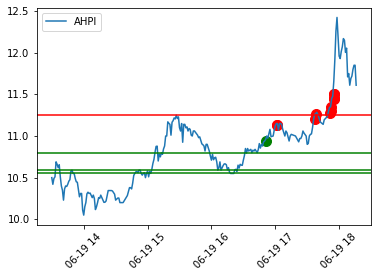

OI analysis for run 1544 with profit -101.43


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-2430.05,-2430.05,buy,2020-06-19 15:34:23.831587,9.17,[9.06],[9.315],265,"{'avg': 8.8615, 'rsi': 69.37291196224638, 'macd': [0.026676889022718697, 0.025919968700051754, 0.026339817806793064, 0.027054630436783356, 0.02930065593963249], 'vwap': 9.17, 'supports': [8.72, 8.745, 8.8, 8.82, 9.06], 'sell_macd': [0.014551031604717934, 0.014103361295436656, 0.014423314803847731, 0.014932066696067281, 0.016433275096549238], 'slow macd': [0.04034450473586304, 0.04018590492827023, 0.040238011374899685, 0.04035914087837611, 0.04080587515425904], 'macd_signal': [0.029316476556907983, 0.028637174985536737, 0.028177703549788, 0.02795308892718707, 0.028222602329676154], 'resistances': [9.315], 'position_ratio': '1.32', 'sell_macd_signal': [0.016147302023601734, 0.015738513877968718, 0.01547547406314452, 0.015366792589729072, 0.015580089091093105]}",9.57,8.97
1,-4429.11,-1999.06,buy,2020-06-19 15:34:24.116815,9.17,[9.06],[9.315],218,"{'avg': 8.8615, 'rsi': 69.37291196224638, 'macd': [0.026676889022718697, 0.025919968700051754, 0.026339817806793064, 0.027054630436783356, 0.02930065593963249], 'vwap': 9.17, 'supports': [8.72, 8.745, 8.8, 8.82, 9.06], 'sell_macd': [0.014551031604717934, 0.014103361295436656, 0.014423314803847731, 0.014932066696067281, 0.016433275096549238], 'slow macd': [0.04034450473586304, 0.04018590492827023, 0.040238011374899685, 0.04035914087837611, 0.04080587515425904], 'macd_signal': [0.029316476556907983, 0.028637174985536737, 0.028177703549788, 0.02795308892718707, 0.028222602329676154], 'resistances': [9.315], 'position_ratio': '1.32', 'sell_macd_signal': [0.016147302023601734, 0.015738513877968718, 0.01547547406314452, 0.015366792589729072, 0.015580089091093105]}",9.57,8.97
2,-101.43,4327.68,sell,2020-06-19 16:18:38.173113,8.96,None,None,483,"{'avg': 8.9048, 'rsi': [24.10217408678735, 20.731064532830874], 'vwap': 8.96, 'reasons': 'stopped', 'movement': -0.022900763358778525, 'sell_macd': [-0.01132716907769371, -0.013340760599893642, -0.015775497362648494, -0.018506779289953812, -0.021953144697075544], 'sell_macd_signal': [-0.008360405703029452, -0.00935647668240229, -0.01064028081845153, -0.012213580512751987, -0.014161493349616697]}",9.57,8.97


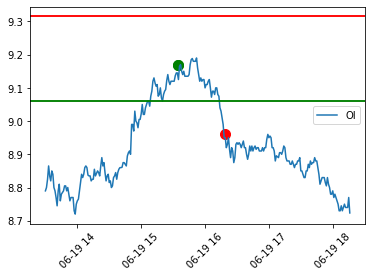

PVG analysis for run 1544 with profit 28.89


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-8137.35,-8137.35,buy,2020-06-19 16:46:28.562909,8.45,[8.36],"[8.54, 8.555]",963,"{'avg': 8.188, 'rsi': 68.76089307009825, 'macd': [0.009251496038437779, 0.010663803367295444, 0.012039670324465845, 0.012581564147611246, 0.013660465984575154], 'vwap': 8.45, 'supports': [8.271, 8.35, 8.355, 8.36, 8.365, 8.4], 'sell_macd': [0.005783943439839234, 0.006667801170406662, 0.0075244721140901305, 0.007834547237557388, 0.008493897369641346], 'slow macd': [0.008916238619772088, 0.009278238971178965, 0.009674820279736096, 0.009944246233303033, 0.010336158322155953], 'macd_signal': [0.008144481953403717, 0.008648346236182063, 0.009326611053838819, 0.009977601672593305, 0.010714174534989674], 'resistances': [8.54, 8.555], 'position_ratio': '1.8', 'sell_macd_signal': [0.005202897080000601, 0.0054958778980818135, 0.005901596741283477, 0.006288186840538259, 0.006729328946358876]}",8.65,8.35
1,28.89,8166.24,sell,2020-06-19 16:51:46.816721,8.48,None,None,963,"{'avg': 8.1924, 'rsi': [76.98517011020436, 79.138422813255], 'vwap': 8.4899, 'reasons': 'rsi max, cool-down for 5 minutes', 'movement': 0.004721893491124398, 'sell_macd': [0.00889736633789262, 0.00961568804902413, 0.011089501225892917, 0.01209390758156026, 0.013233783864135873], 'sell_macd_signal': [0.0071629364246656255, 0.0076534867495373264, 0.008340689644808445, 0.009091333232158808, 0.00991982335855422]}",8.65,8.35


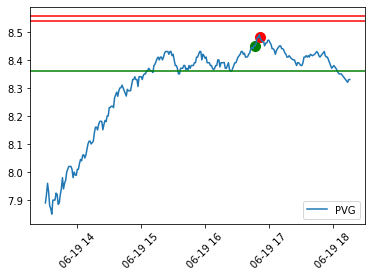

AVCT analysis for run 1544 with profit -96.72


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1736.93,-1736.93,buy,2020-06-19 16:00:29.757761,4.31,[4.12],[4.57],403,"{'avg': 4.2909, 'rsi': 68.50891327569686, 'macd': [-0.006679931937160433, -0.0007706184231111024, 0.006340902061379161, 0.013276242588414533, 0.020951780122833163], 'vwap': 4.31, 'supports': [3.75, 3.86, 4.01, 4.0218, 4.1101, 4.12], 'sell_macd': [-0.003654896317301315, 0.00021557347943268468, 0.0048391139252066395, 0.00931409201379374, 0.014238567251474876], 'slow macd': [0.016437506674625624, 0.01684731202316314, 0.017693202810405317, 0.018731036433036863, 0.020135726964801037], 'macd_signal': [-0.016013640880171737, -0.01296503638875961, -0.009103848698731857, -0.004627830441302579, 0.00048809167152456985], 'resistances': [4.57], 'position_ratio': '1.37', 'sell_macd_signal': [-0.010164240777742297, -0.008088277926307301, -0.0055027995560045125, -0.0025394212420448616, 0.0008161764566590865]}",4.79,4.07
1,-96.72,1640.21,sell,2020-06-19 16:25:12.973608,4.07,None,None,403,"{'avg': 4.2862, 'rsi': [35.365484674248236, 28.831076942457614], 'vwap': 4.0951, 'reasons': 'stopped', 'movement': -0.055684454756380355, 'sell_macd': [-0.007682651558436504, -0.008926555615649256, -0.010818863249637545, -0.01267236448067166, -0.0165494775895203], 'sell_macd_signal': [-0.00393428465084488, -0.004932738843805755, -0.006109963724972113, -0.007422443876112022, -0.009247850618793678]}",4.79,4.07


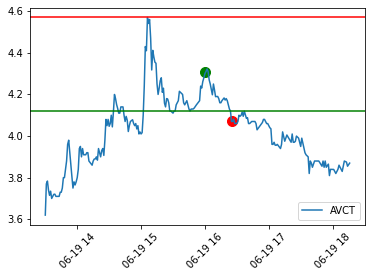

OBCI analysis for run 1546 with profit 105.74


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-3718.40,-3718.40,buy,2020-06-19 17:14:44.433500,8.30,"[7.81, 8.1, 8.11, 8.125, 8.13, 8.1901, 8.27]",[8.49],448,"{'avg': 7.9697, 'rsi': 58.225334326121484, 'macd': [0.029103241428051874, 0.03291882713336847, 0.03154449881550114, 0.03409686838052828, 0.03570801982457539], 'vwap': 8.2751, 'supports': [7.28, 7.405, 7.81, 8.1, 8.11, 8.125, 8.13, 8.1901, 8.27], 'sell_macd': [0.017542966532674953, 0.019962256533313294, 0.018990764890521206, 0.02058452770275565, 0.02155908927459116], 'slow macd': [0.04285361924595321, 0.043487119952906994, 0.04320072916797635, 0.043667827083691435, 0.04402773152020778], 'macd_signal': [0.026920703436112834, 0.02812032817556396, 0.028805162303551395, 0.02986350351894677, 0.031032406780072495], 'resistances': [8.49], 'position_ratio': '6.33', 'sell_macd_signal': [0.016376629044205282, 0.017093754542026884, 0.01747315661172575, 0.01809543082993173, 0.018788162518863616]}",8.62,8.14
1,-4996.60,-1278.20,buy,2020-06-19 17:14:44.601817,8.30,"[7.81, 8.1, 8.11, 8.125, 8.13, 8.1901, 8.27]",[8.49],154,"{'avg': 7.9697, 'rsi': 58.225334326121484, 'macd': [0.029103241428051874, 0.03291882713336847, 0.03154449881550114, 0.03409686838052828, 0.03570801982457539], 'vwap': 8.2751, 'supports': [7.28, 7.405, 7.81, 8.1, 8.11, 8.125, 8.13, 8.1901, 8.27], 'sell_macd': [0.017542966532674953, 0.019962256533313294, 0.018990764890521206, 0.02058452770275565, 0.02155908927459116], 'slow macd': [0.04285361924595321, 0.043487119952906994, 0.04320072916797635, 0.043667827083691435, 0.04402773152020778], 'macd_signal': [0.026920703436112834, 0.02812032817556396, 0.028805162303551395, 0.02986350351894677, 0.031032406780072495], 'resistances': [8.49], 'position_ratio': '6.33', 'sell_macd_signal': [0.016376629044205282, 0.017093754542026884, 0.01747315661172575, 0.01809543082993173, 0.018788162518863616]}",8.62,8.14
2,-2465.19,2531.41,sell,2020-06-19 17:41:40.772958,8.41,None,None,301,"{'avg': 8.005, 'rsi': [63.50357730672089, 65.67739707232639], 'vwap': 8.4011, 'reasons': 'scale-out', 'movement': 0.013253012048192701, 'sell_macd': [0.003963505115653021, 0.0025083310581752727, 0.003939256064580121, 0.010197908588212456, 0.01650078187171644], 'sell_macd_signal': [0.012469719348440681, 0.0104774416903876, 0.009169804565226104, 0.009375425369823375, 0.010800496670201987]}",8.62,8.14
3,-1185.69,1279.50,sell,2020-06-19 17:44:50.146276,8.53,None,None,150,"{'avg': 8.0058, 'rsi': [63.50357730672089, 68.77129837004432], 'vwap': 8.4599, 'reasons': 'scale-out', 'movement': 0.005933412604042707, 'sell_macd': [0.003963505115653021, 0.0025083310581752727, 0.003939256064580121, 0.010197908588212456, 0.019092989663924698], 'sell_macd_signal': [0.012469719348440681, 0.0104774416903876, 0.009169804565226104, 0.009375425369823375, 0.01131893822864364]}",8.62,8.14
4,-544.44,641.25,sell,2020-06-19 17:44:54.872384,8.55,None,None,75,"{'avg': 8.0199, 'rsi': [70.38176370856974, 72.5625079206175], 'vwap': 8.5122, 'reasons': 'scale-out', 'movement': 0.0, 'sell_macd': [0.003939256064580121, 0.010197908588212456, 0.020656626027559355, 0.028538008109810775, 0.03638664339325359], 'sell_macd_signal': [0.009169804565226104, 0.009375425369823375, 0.011631665501370571, 0.015012934023058613, 0.01928767589709761]}",8.62,8.14
5,-218.78,325.66,sell,2020-06-19 17:45:13.474938,8.57,None,None,38,"{'avg': 8.0206, 'rsi': [70.38176370856974, 74.4441453535748], 'vwap': 8.5567, 'reasons': 'scale-out', 'movement': 0.0023391812865496573, 'sell_macd': [0.003939256064580121, 0.010197908588212456, 0.020656626027559355, 0.028538008109810775, 0.0384645654711786], 'sell_macd_signal': [0.009169804565226104, 0.009375425369823375, 0.011631665501370571, 0.015012934023058613, 0.01970326031268261]}",8.62,8.14
6,105.74,324.52,sell,2020-06-19 18:05:58.661285,8.54,None,None,38,"{'avg': 8.0561, 'rsi': [61.133387617773025, 59.78198010146082], 'vwap': 8.57, 'reasons': 'bail', 'movement': 0.0, 'sell_macd': [0.

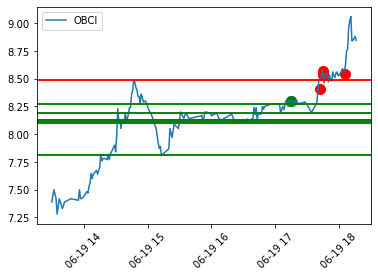

CLLS analysis for run 1546 with profit 37.32


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-8073.50,-8073.50,buy,2020-06-19 17:09:11.315074,16.75,"[16.4, 16.49, 16.6, 16.6, 16.615, 16.65, 16.665, 16.71, 16.71, 16.75]","[16.81, 16.83, 16.86, 16.86, 16.89]",482,"{'avg': 16.5042, 'rsi': 58.850717415802045, 'macd': [-0.012719537182807272, -0.007986202952579902, -0.00657990174140366, 0.00018093142110231497, 0.009464422572111886], 'vwap': 16.745, 'supports': [15.96, 16.4, 16.49, 16.6, 16.6, 16.615, 16.65, 16.665, 16.71, 16.71], 'sell_macd': [-0.0063801774470029216, -0.0033114712840500715, -0.002435707114425867, 0.0019147027205370648, 0.007877168790368927], 'slow macd': [0.00394842185432509, 0.004153322210100896, 0.0038553863563635105, 0.004694661868207106, 0.0062589938575250414], 'macd_signal': [-0.028638075641497368, -0.024507701103713874, -0.020922141231251832, -0.016701526700781004, -0.011468336846202427], 'resistances': [16.81, 16.83, 16.86, 16.86, 16.89, 17.1], 'position_ratio': '1.5', 'sell_macd_signal': [-0.017174377703213364, -0.014401796419380705, -0.012008578558389738, -0.009223922302604378, -0.005803704084009717]}",17.15,16.55
1,-4019.88,4053.62,sell,2020-06-19 17:33:44.885054,16.82,None,None,241,"{'avg': 16.5168, 'rsi': [61.97389517349154, 61.973895173491556], 'vwap': 16.82, 'reasons': 'scale-out', 'movement': 0.004179104477611957, 'sell_macd': [0.02135616932379847, 0.020074294277513616, 0.02037316704304004, 0.021899909885746638, 0.02280516521921072], 'sell_macd_signal': [0.021115169456347734, 0.02090699442058091, 0.020800228945072736, 0.021020165133207515, 0.021377165150408155]}",17.15,16.55
2,-2000.28,2019.60,sell,2020-06-19 17:33:51.171917,16.83,None,None,120,"{'avg': 16.518, 'rsi': [61.97389517349154, 62.961782983804014], 'vwap': 16.8233, 'reasons': 'scale-out', 'movement': 0.000594530321046255, 'sell_macd': [0.02135616932379847, 0.020074294277513616, 0.02037316704304004, 0.021899909885746638, 0.023324645738693306], 'sell_macd_signal': [0.021115169456347734, 0.02090699442058091, 0.020800228945072736, 0.021020165133207515, 0.021481061254304674]}",17.15,16.55
3,-987.48,1012.80,sell,2020-06-19 17:52:53.958269,16.88,None,None,60,"{'avg': 16.5305, 'rsi': [59.9569727041579, 58.474077346297406], 'vwap': 16.88, 'reasons': 'scale-out', 'movement': 0.0029708853238265428, 'sell_macd': [0.026209125148476176, 0.027928281077510775, 0.028905178151074296, 0.028252043686954664, 0.026856717563138233], 'sell_macd_signal': [0.02381538602184316, 0.02463796503297668, 0.025491407656596205, 0.026043534862667896, 0.026206171402761963]}",17.15,16.55
4,37.32,1024.80,sell,2020-06-19 17:53:05.950658,16.80,None,None,61,"{'avg': 16.5328, 'rsi': [54.43510284479209, 57.589834233384686], 'vwap': 16.8868, 'reasons': 'bail', 'movement': 0.0, 'sell_macd': [0.027928281077510775, 0.028905178151074296, 0.028252043686954664, 0.02529827600469403, 0.024226531369102133], 'sell_macd_signal': [0.02463796503297668, 0.025491407656596205, 0.026043534862667896, 0.025894483091073124, 0.025560892746678925]}",17.15,16.55


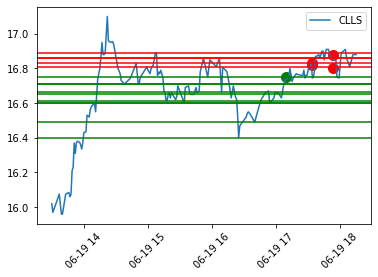

CUTR analysis for run 1546 with profit -132.33


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-5854.60,-5854.60,buy,2020-06-19 17:14:28.414395,14.60,"[14.105, 14.19]",[14.73],401,"{'avg': 14.2301, 'rsi': 67.57002385678342, 'macd': [0.053236321132228426, 0.05345417927932061, 0.05193080114066895, 0.05442125073413884, 0.054954551689316844], 'vwap': 14.5921, 'supports': [14.105, 14.19, 14.42, 14.4668], 'sell_macd': [0.03154909167977138, 0.031589837762762585, 0.030504836817526026, 0.03204763040802305, 0.032314123719995536], 'slow macd': [0.029277385117849164, 0.030585860484121596, 0.031523268871108456, 0.033192554606003455, 0.03451532799967438], 'macd_signal': [0.05506056705832463, 0.054739289502523825, 0.054177591830152846, 0.05422632361095005, 0.05437196922662341], 'resistances': [14.73], 'position_ratio': '0.98', 'sell_macd_signal': [0.033371635503893875, 0.03301527595566762, 0.0325131881280393, 0.03242007658403605, 0.032398886011227944]}",15.08,14.36
1,-132.33,5722.27,sell,2020-06-19 17:48:16.845484,14.27,None,None,401,"{'avg': 14.2576, 'rsi': [36.958523588094586, 27.07869366215337], 'vwap': 14.2757, 'reasons': 'stopped', 'movement': -0.0226027397260274, 'sell_macd': [-0.008505252912190286, -0.009612448581297173, -0.009311400419804272, -0.012851994054747351, -0.021677755405940857], 'sell_macd_signal': [0.002561623639111074, 0.00012680919502942433, -0.0017608327279373152, -0.003979064993299322, -0.00751880307582763]}",15.08,14.36


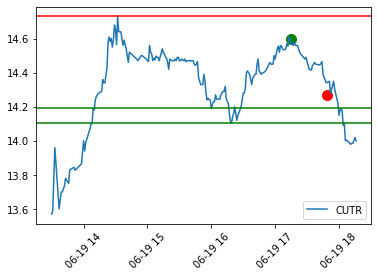

BCLI analysis for run 1546 with profit -120.9


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-8245.38,-8245.38,buy,2020-06-19 16:04:44.595115,10.23,[10.16],"[10.3276, 10.3399]",806,"{'avg': 10.0634, 'rsi': 68.18095898365867, 'macd': [0.010633950772318101, 0.011004294686429716, 0.011169045107040532, 0.015159444495189689, 0.018113068579975078], 'vwap': 10.2264, 'supports': [9.79, 9.89, 9.92, 9.96, 10.025, 10.11, 10.1101, 10.12, 10.16], 'sell_macd': [0.005760557047295833, 0.0060246554953291565, 0.006152204214634693, 0.00876909666845016, 0.010694349273132175], 'slow macd': [0.0231353482418033, 0.02300951952464203, 0.02285695256890996, 0.02347970971588431, 0.024015113696822965], 'macd_signal': [0.011776241385880728, 0.011621852045990526, 0.011531290658200527, 0.012256921425598359, 0.013428150856473703], 'resistances': [10.3094, 10.3276, 10.3399, 10.3399], 'position_ratio': '1.13', 'sell_macd_signal': [0.006392241546216726, 0.0063187243360392125, 0.006285420311758308, 0.006782155583096678, 0.007564594321103778]}",10.47,10.11
1,-120.90,8124.48,sell,2020-06-19 16:21:48.579293,10.08,None,None,806,"{'avg': 10.0745, 'rsi': [33.826480100284954, 28.943695861582064], 'vwap': 10.0805, 'reasons': 'stopped', 'movement': -0.014613880742912975, 'sell_macd': [0.010075834182073251, 0.004799704566517349, -0.0001531198685462698, -0.004010475014458947, -0.008756329998099943], 'sell_macd_signal': [0.01080634134810263, 0.009605013991785575, 0.007653387219719206, 0.005320614772883574, 0.0025052258186868707]}",10.47,10.11


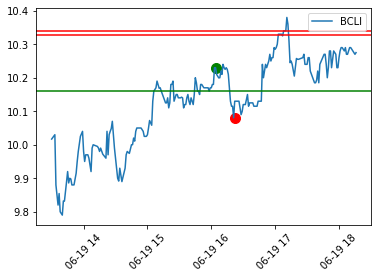

EVC analysis for run 1543 with profit 35.84


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1058.94,-1058.94,buy,2020-06-19 15:48:18.396728,2.22,"[2.065, 2.09]",[2.37],477,"{'avg': 2.0226, 'rsi': 65.36043325257998, 'macd': [0.008650384253657606, 0.008166070402849446, 0.010485584389790414, 0.01696969837511686, 0.022071842399231656], 'vwap': 2.2227, 'supports': [1.71, 1.7401, 1.76, 2.065, 2.09], 'sell_macd': [0.002930563901372807, 0.0027647151935363823, 0.004417758860240983, 0.008765354459488783, 0.012179515258129658], 'slow macd': [0.04269325493693632, 0.04188139457419604, 0.04162724972295173, 0.042286467515192605, 0.04286852040199207], 'macd_signal': [0.012415496872316948, 0.011565611578423448, 0.011349606140696841, 0.012473624587580844, 0.014393268149911006], 'resistances': [2.37], 'position_ratio': '1.11', 'sell_macd_signal': [0.004732536582477546, 0.004338972304689314, 0.004354729615799647, 0.005236854584537475, 0.006625386719255911]}",2.63,2.02
1,-521.06,537.88,sell,2020-06-19 15:52:41.000177,2.26,None,None,238,"{'avg': 2.0334, 'rsi': [67.21485888843763, 69.38983812730292], 'vwap': 2.2522, 'reasons': 'scale-out', 'movement': 0.0224774774774773, 'sell_macd': [0.01300548928410361, 0.015527600974919231, 0.017717199682373952, 0.019972507770229964, 0.02250427371180308], 'sell_macd_signal': [0.006790581524450702, 0.008537985414544407, 0.010373828268110317, 0.012293564168534245, 0.014335706077188013]}",2.63,2.02
2,-247.36,273.70,sell,2020-06-19 15:53:10.949490,2.30,None,None,119,"{'avg': 2.0366, 'rsi': [70.97661857172413, 72.97302612505047], 'vwap': 2.3031, 'reasons': 'scale-out', 'movement': 0.021238938053097366, 'sell_macd': [0.015527600974919231, 0.017717199682373952, 0.019972507770229964, 0.023356221763751073, 0.026816827190342174], 'sell_macd_signal': [0.008537985414544407, 0.010373828268110317, 0.012293564168534245, 0.014506095687577611, 0.016968241988130524]}",2.63,2.02
3,-107.56,139.80,sell,2020-06-19 15:53:23.937410,2.33,None,None,60,"{'avg': 2.0375, 'rsi': [70.97661857172413, 75.44792150508933], 'vwap': 2.3399, 'reasons': 'scale-out', 'movement': 0.01730434782608698, 'sell_macd': [0.015527600974919231, 0.017717199682373952, 0.019972507770229964, 0.023356221763751073, 0.02846877524229008], 'sell_macd_signal': [0.008537985414544407, 0.010373828268110317, 0.012293564168534245, 0.014506095687577611, 0.017298631598520103]}",2.63,2.02
4,-35.86,71.70,sell,2020-06-19 15:54:19.956026,2.39,None,None,30,"{'avg': 2.0427, 'rsi': [74.74242362634442, 76.93516316742014], 'vwap': 2.36, 'reasons': 'scale-out', 'movement': 0.01283261802575109, 'sell_macd': [0.017717199682373952, 0.019972507770229964, 0.023356221763751073, 0.027964879138394405, 0.03274091242852695], 'sell_macd_signal': [0.010373828268110317, 0.012293564168534245, 0.014506095687577611, 0.01719785237774097, 0.020306464387898165]}",2.63,2.02
5,35.84,71.70,sell,2020-06-19 15:54:23.846565,2.39,None,None,30,"{'avg': 2.0459, 'rsi': [74.74242362634442, 79.34778930716325], 'vwap': 2.3898, 'reasons': 'rsi max, cool-down for 5 minutes', 'movement': 0.004184100418409952, 'sell_macd': [0.017717199682373952, 0.019972507770229964, 0.023356221763751073, 0.027964879138394405, 0.0348240293116433], 'sell_macd_signal': [0.010373828268110317, 0.012293564168534245, 0.014506095687577611, 0.01719785237774097, 0.020723087764521437]}",2.63,2.02


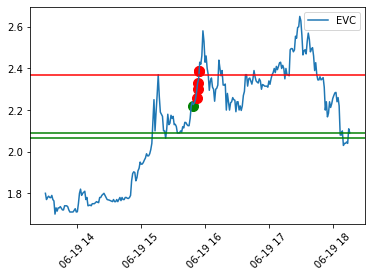

LMFA analysis for run 1543 with profit -17.94


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-687.24,-687.24,buy,2020-06-19 16:14:11.344094,2.49,[2.22],"[2.85, 2.88]",276,"{'avg': 2.4102, 'rsi': 61.810955629392836, 'macd': [-0.04112589832663893, -0.026446559545210135, -0.014636290590583911, -0.004418714736212248, 0.0052323058304462045], 'vwap': 2.4963, 'supports': [1.87, 1.8761, 1.9003, 2.05, 2.22], 'sell_macd': [-0.02428982656505685, -0.014601234381126371, -0.006856860804282938, -0.00021375333136175456, 0.0060044311063864875], 'slow macd': [0.01184687080190061, 0.012797037569602931, 0.013652353676042228, 0.014577372846859227, 0.015724977653201577], 'macd_signal': [-0.05784789927301991, -0.05156763132745796, -0.04418136318008315, -0.03622883349130897, -0.027936605626957933], 'resistances': [2.85, 2.88], 'position_ratio': '1.25', 'sell_macd_signal': [-0.036446151502162606, -0.03207716807795536, -0.027033106623220875, -0.02166923596484905, -0.01613450255060194]}",3.2,2.15
1,-338.10,349.14,sell,2020-06-19 16:15:35.387791,2.53,None,None,138,"{'avg': 2.4105, 'rsi': [60.55332333048028, 65.08531209716998], 'vwap': 2.5384, 'reasons': 'scale-out', 'movement': 0.020040160642570123, 'sell_macd': [-0.014601234381126371, -0.006856860804282938, -0.00021375333136175456, 0.005225210327165275, 0.012247452004885861], 'sell_macd_signal': [-0.03207716807795536, -0.027033106623220875, -0.02166923596484905, -0.016290346706446183, -0.010582786964179774]}",3.2,2.15
2,-158.70,179.40,sell,2020-06-19 16:15:39.560719,2.60,None,None,69,"{'avg': 2.411, 'rsi': [60.55332333048028, 68.98597695113338], 'vwap': 2.597, 'reasons': 'scale-out', 'movement': 0.027667984189723435, 'sell_macd': [-0.014601234381126371, -0.006856860804282938, -0.00021375333136175456, 0.005225210327165275, 0.015369529926963832], 'sell_macd_signal': [-0.03207716807795536, -0.027033106623220875, -0.02166923596484905, -0.016290346706446183, -0.009958371379764179]}",3.2,2.15
3,-17.94,140.76,sell,2020-06-19 17:18:16.888924,2.04,None,None,69,"{'avg': 2.4118, 'rsi': [32.69785070712533, 31.840777175858175], 'vwap': 2.1502, 'reasons': 'stopped', 'movement': -0.17307692307692313, 'sell_macd': [-0.02205070170282486, -0.023615329315521905, -0.025047307594045165, -0.027915767192971508, -0.030307868605213617], 'sell_macd_signal': [-0.013553835433832259, -0.015566134210170187, -0.017462368886945183, -0.01955304854815045, -0.02170401255956308]}",3.2,2.15


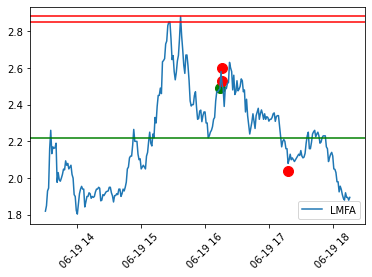

UGAZ analysis for run 1543 with profit -121.72


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-3625.44,-3625.44,buy,2020-06-19 15:34:06.805480,10.92,[10.71],"[10.99, 11.02, 11.03]",332,"{'avg': 10.689, 'rsi': 67.74864958518287, 'macd': [0.021810480186859493, 0.02450401915575995, 0.028640506733607296, 0.03283928752270526, 0.03615355409510279], 'vwap': 10.9191, 'supports': [10.435, 10.6207, 10.7018, 10.71, 10.7118, 10.76, 10.81], 'sell_macd': [0.014626410296511239, 0.016258005433341438, 0.018819534040828145, 0.021407484461715143, 0.023405790186281195], 'slow macd': [0.01573799156550848, 0.01654905392818229, 0.017731004460289412, 0.019047575494489877, 0.020308367036960817], 'macd_signal': [0.007651186538611885, 0.011021753062041497, 0.014545503796354657, 0.01820426054162478, 0.02179411925232038], 'resistances': [11.02, 11.03], 'position_ratio': '0.91', 'sell_macd_signal': [0.005567203090633485, 0.007705363559175076, 0.00992819765550569, 0.01222405501674758, 0.014460402050654303]}",11.46,10.65
1,-3909.36,-283.92,buy,2020-06-19 15:34:07.080962,10.92,[10.71],"[10.99, 11.02, 11.03]",26,"{'avg': 10.689, 'rsi': 67.74864958518287, 'macd': [0.021810480186859493, 0.02450401915575995, 0.028640506733607296, 0.03283928752270526, 0.03615355409510279], 'vwap': 10.9191, 'supports': [10.435, 10.6207, 10.7018, 10.71, 10.7118, 10.76, 10.81], 'sell_macd': [0.014626410296511239, 0.016258005433341438, 0.018819534040828145, 0.021407484461715143, 0.023405790186281195], 'slow macd': [0.01573799156550848, 0.01654905392818229, 0.017731004460289412, 0.019047575494489877, 0.020308367036960817], 'macd_signal': [0.007651186538611885, 0.011021753062041497, 0.014545503796354657, 0.01820426054162478, 0.02179411925232038], 'resistances': [11.02, 11.03], 'position_ratio': '0.91', 'sell_macd_signal': [0.005567203090633485, 0.007705363559175076, 0.00992819765550569, 0.01222405501674758, 0.014460402050654303]}",11.46,10.65
2,-121.72,3787.64,sell,2020-06-19 16:44:41.921263,10.58,None,None,358,"{'avg': 10.7081, 'rsi': [39.47863109909263, 31.069335416261097], 'vwap': 10.6454, 'reasons': 'stopped', 'movement': -0.02564102564102558, 'sell_macd': [-0.006715873378656312, -0.008026476166728358, -0.009457770856567294, -0.009935951512849428, -0.012776924082512409], 'sell_macd_signal': [-0.007668180501651518, -0.007739839634666886, -0.008083425879046967, -0.00845393100580746, -0.00931852962114845]}",11.46,10.65


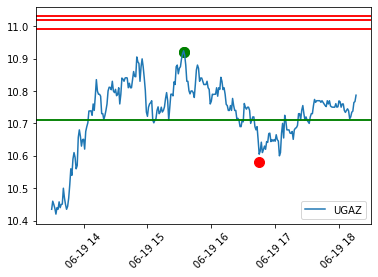

DGLY analysis for run 1543 with profit 43.47


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-2057.58,-2057.58,buy,2020-06-19 15:37:07.840459,4.26,"[4.06, 4.11, 4.12]","[4.42, 4.4401, 4.47]",483,"{'avg': 4.0999, 'rsi': 67.31100276249062, 'macd': [0.024211578518169574, 0.024072700000018266, 0.024495257286366368, 0.024946032855027944, 0.02700922131645811], 'vwap': 4.2474, 'supports': [3.9363, 3.98, 4.06, 4.11, 4.12], 'sell_macd': [0.014816372504570907, 0.014671829668224667, 0.014893330968886787, 0.015132249762014993, 0.01642059882468594], 'slow macd': [0.01960994931690241, 0.019946170631649274, 0.020385139269277097, 0.02083636928851096, 0.021618030542850164], 'macd_signal': [0.017369716838809522, 0.01871031347105127, 0.01986730223411429, 0.020883048358297022, 0.02210828294992924], 'resistances': [4.42], 'position_ratio': '1.14', 'sell_macd_signal': [0.010415754657465895, 0.01126696965961765, 0.011992241921471478, 0.012620243489580182, 0.013380314556601334]}",4.66,4.06
1,43.47,2101.05,sell,2020-06-19 15:43:17.201710,4.35,None,None,483,"{'avg': 4.1199, 'rsi': [75.73123128694328, 80.83008590988082], 'vwap': 4.3701, 'reasons': 'rsi max, cool-down for 5 minutes', 'movement': 0.025821596244131533, 'sell_macd': [0.019132378349350887, 0.020402475764583983, 0.02242589614314827, 0.023971082202507432, 0.027461213129248208], 'sell_macd_signal': [0.015245911177131687, 0.016277224094622147, 0.01750695850432737, 0.018799783243963385, 0.020532069221020348]}",4.66,4.06


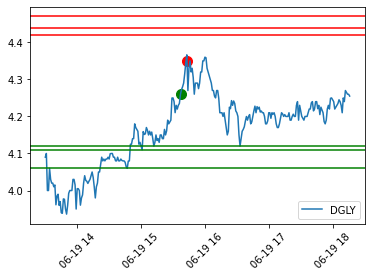

CBAY analysis for run 1543 with profit -96.85


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-2980.00,-2980.00,buy,2020-06-19 15:49:27.910977,4.00,[3.93],[4.0082],745,"{'avg': 3.9034, 'rsi': 66.04583763530407, 'macd': [0.001402511433342024, 0.003246547200221883, 0.005356301180537759, 0.007586378502089985, 0.009239158414962922], 'vwap': 4.0099, 'supports': [3.7, 3.8101, 3.84, 3.93], 'sell_macd': [0.0008167801974678923, 0.002029305682217153, 0.0034049189731617524, 0.004848190122298313, 0.005904658678479002], 'slow macd': [0.014816457381809034, 0.014812576058128357, 0.014926058173273304, 0.015134542025434516, 0.015300548892976273], 'macd_signal': [-0.0016647862997475518, -0.0006825195997536646, 0.0005252445563046202, 0.0019374713454616934, 0.003397808759361939], 'resistances': [4.11], 'position_ratio': '1.25', 'sell_macd_signal': [-0.0013708296333210124, -0.0006908025702133794, 0.000128341738461647, 0.0010723114152289804, 0.002038780867878985]}",4.27,3.88
1,-96.85,2883.15,sell,2020-06-19 16:14:58.153465,3.87,None,None,745,"{'avg': 3.9054, 'rsi': [32.397655545249094, 23.979534024355505], 'vwap': 3.8962, 'reasons': 'stopped', 'movement': -0.030000000000000027, 'sell_macd': [-0.0023922094159556373, -0.002094450733936881, -0.0027806848682869756, -0.0047078714032573465, -0.00835622621747767], 'sell_macd_signal': [-0.002155202604580575, -0.0021430522304518363, -0.0022705787580188644, -0.0027580372870665607, -0.0038776750731487823]}",4.27,3.88


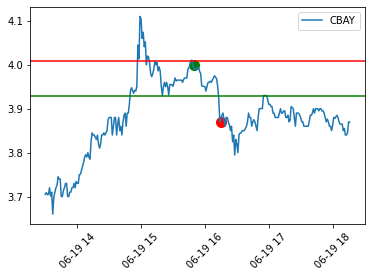

GNUS analysis for run 1547 with profit -95.76


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1193.01,-1193.01,buy,2020-06-19 15:33:36.650175,2.99,[2.7668],"[2.99, 3.0]",399,"{'avg': 2.9632, 'rsi': 69.53107311254503, 'macd': [0.02741183841312589, 0.03011725693146783, 0.035084553412430886, 0.03777078793839994, 0.039636404299904004], 'vwap': 2.9978, 'supports': [2.815], 'sell_macd': [0.016588212744451436, 0.018290376403368835, 0.021457122418066188, 0.02312137746305032, 0.024242597271309396], 'slow macd': [0.014948348234485653, 0.0161247677415699, 0.017821066108156813, 0.019191677174563715, 0.020460373438100365], 'macd_signal': [0.02247676412108924, 0.024004862683164957, 0.02622080082901814, 0.028530798250894503, 0.030751919460696404], 'resistances': [3.94], 'position_ratio': '5.35', 'sell_macd_signal': [0.013581680018967252, 0.014523419295847568, 0.01591015992029129, 0.017352403428843095, 0.018730442197336356]}",3.48,2.75
1,-95.76,1097.25,sell,2020-06-19 15:49:15.023667,2.75,None,None,399,"{'avg': 2.9198, 'rsi': [25.870658767465887, 22.654772160995993], 'vwap': 2.755, 'reasons': 'stopped', 'movement': -0.08026755852842817, 'sell_macd': [-0.004488031672928994, -0.005262628091756927, -0.006057604157184482, -0.006858136102229739, -0.007912341045093196], 'sell_macd_signal': [-0.004864799200077664, -0.004944364978413517, -0.005167012814167709, -0.0055052374717801155, -0.005986658186442732]}",3.48,2.75


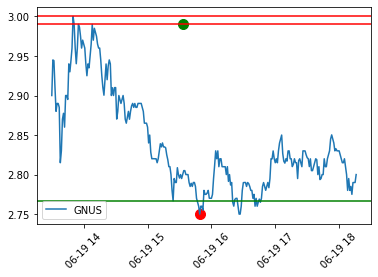

ELMD analysis for run 1547 with profit -3193.52


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-3193.52,-3193.52,buy,2020-06-19 17:01:52.501853,15.28,"[14.41, 14.555, 14.81, 14.8205, 14.87, 14.87, 14.885, 14.9, 14.9001, 14.98, 14.985, 15.0, 15.0601, 15.1572, 15.22]",[15.33],209,"{'avg': 14.9744, 'rsi': 62.80042161421906, 'macd': [-0.01090923986142478, 0.0027710066807724587, 0.003095176972456315, 0.019260322620100467, 0.033301273510762286], 'vwap': 15.275, 'supports': [14.41, 14.555, 14.81, 14.8205, 14.87, 14.87, 14.885, 14.9, 14.9001, 14.98, 14.985, 15.0, 15.03, 15.03, 15.0601, 15.1572, 15.22], 'sell_macd': [-0.008676372460435289, 0.00044416040268480117, 0.0007972488622254303, 0.011446444429887848, 0.020634824814692365], 'slow macd': [0.018865108517889695, 0.020815597171196742, 0.020499248511690382, 0.023372533094029535, 0.02629853776879365], 'macd_signal': [-0.015310642788751045, -0.011694312894846345, -0.008736414921385813, -0.0031370674130885567, 0.004150600771681612], 'resistances': [15.33], 'position_ratio': '0.83', 'sell_macd_signal': [-0.012715911762684847, -0.010083897329610918, -0.007907668091243648, -0.004036845587017349, 0.0008974884933245948]}",16.2,14.82


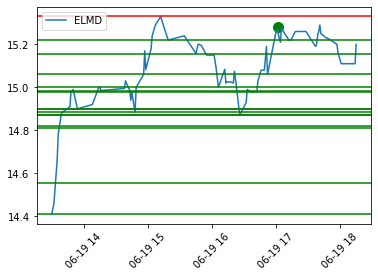

GNUS analysis for run 1540 with profit -1193.01


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1193.01,-1193.01,buy,2020-06-19 13:52:09.377031,2.99,"[2.815, 2.95]","[3.8701, 3.89, 3.94]",399,"{'avg': 2.9632, 'rsi': 69.53107311254503, 'macd': [0.02741183841312589, 0.03011725693146783, 0.035084553412430886, 0.03777078793839994, 0.039636404299904004], 'vwap': 2.9978, 'supports': [2.815], 'sell_macd': [0.016588212744451436, 0.018290376403368835, 0.021457122418066188, 0.02312137746305032, 0.024242597271309396], 'slow macd': [0.014948348234485653, 0.0161247677415699, 0.017821066108156813, 0.019191677174563715, 0.020460373438100365], 'macd_signal': [0.02247676412108924, 0.024004862683164957, 0.02622080082901814, 0.028530798250894503, 0.030751919460696404], 'resistances': [3.94], 'position_ratio': '5.35', 'sell_macd_signal': [0.013581680018967252, 0.014523419295847568, 0.01591015992029129, 0.017352403428843095, 0.018730442197336356]}",3.48,2.75


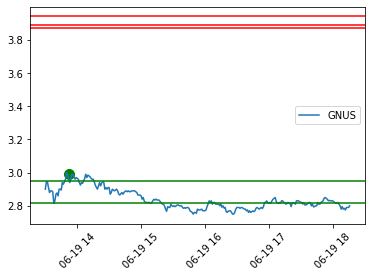

In [112]:
for batch_id, count in batch.items():
    for run_id in batch[batch_id]:
        for symbol in minute_history:    
            if symbol not in trade_details[run_id]:
                continue
            start_date = datetime.strptime(start_day_to_analyze, "%Y-%m-%d") + timedelta(hours=9, minutes=30)
            minute_history_index = minute_history[symbol]["close"].index.get_loc(start_date, method='nearest')
            plt.plot(minute_history[symbol]["close"][minute_history_index:].between_time("9:30", "16:00"), label=symbol)
            plt.xticks(rotation=45)
            delta = 0
            profit = 0

            operations = []
            deltas = []
            profits = []
            times = []
            prices = []
            qtys = []
            indicators = []
            target_price = []
            stop_price = []
            resistances = []
            supports = []
            for trade in trade_details[run_id][symbol]:
                resistance = None
                support = None
                if trade[0] == 'buy':
                    resistance = find_resistance(trade[2], minute_history[symbol], trade[1])

                    for r in resistance:
                        plt.axhline(y=r, color="r")
                    support = find_support(trade[2], minute_history[symbol], trade[1])
                    for s in support:
                        plt.axhline(y=s, color="g")  

                delta = trade[2] * trade[3] * (1 if trade[0] == 'sell' or trade[0] == 'buy_short' else -1)
                profit += delta
                plt.scatter(pd.to_datetime(trade[1]), trade[2], c='g' if trade[0] == 'buy' or trade[0] == 'sell_short' else 'r', s=100)
                deltas.append(round(delta, 2))
                profits.append(round(profit, 2))
                operations.append(trade[0])
                times.append(pd.to_datetime(trade[1]))
                prices.append(trade[2])
                qtys.append(trade[3])
                indicators.append(trade[4])
                target_price.append(trade[6])
                stop_price.append(trade[5])    
                resistances.append(resistance)
                supports.append(support)
            d = {
                'profit': profits,
                'trade': deltas,
                'operation': operations,
                'at': times,
                'price': prices,
                'support': supports,
                'resistance': resistances,
                'qty': qtys,
                'indicators': indicators,
                'target price': target_price,
                'stop price': stop_price
            }   
            print (f'{symbol} analysis for run {run_id} with profit {round(profit, 2)}')
            display(HTML(pd.DataFrame(data=d).to_html()))
            plt.legend()
            plt.show()

In [15]:
 pd.Timestamp('2020-04-16 13:44:06.066') 

Timestamp('2020-04-16 13:44:06.066000')

In [ ]:
index = minute_history['NURO'].index.get_loc(pd.Timestamp('2020-04-16 13:44:06.066') , method='nearest')

In [ ]:
minute_history['NURO'][:index]

In [ ]:
series = minute_history['NURO'][:2417]['close']

In [ ]:
MACD(series.dropna().between_time("9:30", "16:00"))

AHPI analysis with profit 127.23


,profit,trade,operation,at,price,support,resistance,qty,daily change,vwap,indicators,target price,stop price
0,-5546.58,-5546.58,buy,2020-06-19 16:51:05.554154,10.94,"[10.55, 10.59, 10.8]",[11.25],507,2.63%,0.61%,"{'avg': 10.7251, 'rsi': 63.20253255111518, 'macd': [0.04416141209736146, 0.04716405601669216, 0.04738363109859911, 0.05099630523857179, 0.054051291470875285], 'vwap': 10.94, 'supports': [10.5, 10.55, 10.59, 10.8, 10.925], 'sell_macd': [0.029392311574401475, 0.031047089329554467, 0.03089435655006767, 0.03296632637709074, 0.03467738953610677], 'slow macd': [0.003814356428783583, 0.005787313438389674, 0.007273368946327352, 0.009427035578864817, 0.0115549359303877], 'macd_signal': [0.033789973694357336, 0.0364647901588243, 0.03864855834677926, 0.04111810772513776, 0.04370474447428527], 'resistances': [11.25], 'position_ratio': '20.67', 'sell_macd_signal': [0.023881087901228573, 0.02531428818689375, 0.026430301859528535, 0.027737506763040976, 0.029125483317654136]}",11.32,10.75
1,-3175.89,2370.69,sell,2020-06-19 17:01:26.715083,11.13,"[10.55, 10.59, 10.8]",[11.25],213,4.41%,0.67%,"{'avg': 10.7311, 'rsi': [65.91498708267513, 67.66947404330448], 'vwap': 11.0825, 'reasons': 'scale-out', 'movement': 0.014625228519195626, 'sell_macd': [0.045671683447656264, 0.0451371792560753, 0.044134485350218355, 0.04641635392552246, 0.04915006510205089], 'sell_macd_signal': [0.03633659890237066, 0.03809671497311159, 0.039304269048532944, 0.04072668602393085, 0.04241136183955486]}",11.32,10.75
2,-2730.69,445.20,sell,2020-06-19 17:01:27.926436,11.13,"[10.55, 10.59, 10.8]",[11.25],40,4.41%,0.67%,"{'avg': 10.7311, 'rsi': [65.91498708267513, 67.66947404330448], 'vwap': 11.0825, 'reasons': 'scale-out', 'movement': 0.014625228519195626, 'sell_macd': [0.045671683447656264, 0.0451371792560753, 0.044134485350218355, 0.04641635392552246, 0.04915006510205089], 'sell_macd_signal': [0.03633659890237066, 0.03809671497311159, 0.039304269048532944, 0.04072668602393085, 0.04241136183955486]}",11.32,10.75
3,-1307.02,1423.67,sell,2020-06-19 17:37:43.486344,11.21,"[10.55, 10.59, 10.8]",[11.25],127,5.16%,0.85%,"{'avg': 10.7501, 'rsi': [58.72630991401413, 64.87116196697517], 'vwap': 11.1714, 'reasons': 'scale-out', 'movement': 0.006289308176100495, 'sell_macd': [-0.005388045721264945, -0.0031819101981334086, -0.0011617797879246439, 0.004323539749742977, 0.013736470042083226], 'sell_macd_signal': [0.0023933429148318653, 0.0012782922922388105, 0.0007902778762061196, 0.0014969302509134912, 0.003944838209147438]}",11.32,10.75
4,-597.01,710.01,sell,2020-06-19 17:38:08.962850,11.27,"[10.55, 10.59, 10.8]",[11.25],63,5.72%,0.87%,"{'avg': 10.7531, 'rsi': [64.87116196697517, 67.95398177817759], 'vwap': 11.2528, 'reasons': 'scale-out', 'movement': 0.004460303300624347, 'sell_macd': [-0.0031819101981334086, -0.0011617797879246439, 0.004323539749742977, 0.013736470042083226, 0.024009708321283796], 'sell_macd_signal': [0.0012782922922388105, 0.0007902778762061196, 0.0014969302509134912, 0.003944838209147438, 0.007957812231574709]}",11.32,10.75
5,-236.05,360.96,sell,2020-06-19 17:51:01.117269,11.28,"[10.55, 10.59, 10.8]",[11.25],32,5.82%,1.05%,"{'avg': 10.7717, 'rsi': [60.80551255644791, 63.74576631096115], 'vwap': 11.28, 'reasons': 'scale-out', 'movement': 0.0008784383318544827, 'sell_macd': [0.039620675369956615, 0.03509315534805957, 0.03396660526153994, 0.034720376554362886, 0.037194479164947225], 'sell_macd_signal': [0.02937418502158292, 0.03051797908687825, 0.031207704321810588, 0.031910238768321046, 0.03296708684764628]}",11.32,10.75
6,-55.25,180.80,sell,2020-06-19 17:52:11.174168,11.30,"[10.55, 10.59, 10.8]",[11.25],16,6.0%,1.08%,"{'avg': 10.7755, 'rsi': [64.92117371258459, 64.9211737125846], 'vwap': 11.3, 'reasons': 'scale-out', 'movement': 0.0017730496453901908, 'sell_macd': [0.03509315534805957, 0.03396660526153994, 0.034720376554362886, 0.03823863500910285, 0.040483529454236944], 'sell_macd_signal': [0.03051797908687825, 0.031207704321810588, 0.031910238768321046, 0.

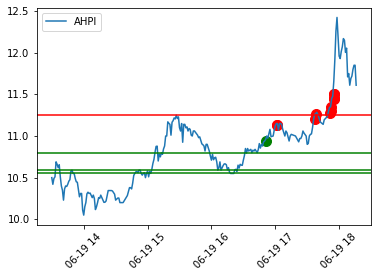

OI analysis with profit -101.43


,profit,trade,operation,at,price,support,resistance,qty,daily change,vwap,indicators,target price,stop price
0,-2430.05,-2430.05,buy,2020-06-19 15:34:23.831587,9.17,[9.06],[9.14],265,3.97%,0.47%,"{'avg': 8.8615, 'rsi': 69.37291196224638, 'macd': [0.026676889022718697, 0.025919968700051754, 0.026339817806793064, 0.027054630436783356, 0.02930065593963249], 'vwap': 9.17, 'supports': [8.72, 8.745, 8.8, 8.82, 9.06], 'sell_macd': [0.014551031604717934, 0.014103361295436656, 0.014423314803847731, 0.014932066696067281, 0.016433275096549238], 'slow macd': [0.04034450473586304, 0.04018590492827023, 0.040238011374899685, 0.04035914087837611, 0.04080587515425904], 'macd_signal': [0.029316476556907983, 0.028637174985536737, 0.028177703549788, 0.02795308892718707, 0.028222602329676154], 'resistances': [9.315], 'position_ratio': '1.32', 'sell_macd_signal': [0.016147302023601734, 0.015738513877968718, 0.01547547406314452, 0.015366792589729072, 0.015580089091093105]}",9.57,8.97
1,-4429.11,-1999.06,buy,2020-06-19 15:34:24.116815,9.17,[9.06],[9.14],218,3.97%,0.47%,"{'avg': 8.8615, 'rsi': 69.37291196224638, 'macd': [0.026676889022718697, 0.025919968700051754, 0.026339817806793064, 0.027054630436783356, 0.02930065593963249], 'vwap': 9.17, 'supports': [8.72, 8.745, 8.8, 8.82, 9.06], 'sell_macd': [0.014551031604717934, 0.014103361295436656, 0.014423314803847731, 0.014932066696067281, 0.016433275096549238], 'slow macd': [0.04034450473586304, 0.04018590492827023, 0.040238011374899685, 0.04035914087837611, 0.04080587515425904], 'macd_signal': [0.029316476556907983, 0.028637174985536737, 0.028177703549788, 0.02795308892718707, 0.028222602329676154], 'resistances': [9.315], 'position_ratio': '1.32', 'sell_macd_signal': [0.016147302023601734, 0.015738513877968718, 0.01547547406314452, 0.015366792589729072, 0.015580089091093105]}",9.57,8.97
2,-101.43,4327.68,sell,2020-06-19 16:18:38.173113,8.96,[9.06],[9.14],483,1.59%,0.96%,"{'avg': 8.9048, 'rsi': [24.10217408678735, 20.731064532830874], 'vwap': 8.96, 'reasons': 'stopped', 'movement': -0.022900763358778525, 'sell_macd': [-0.01132716907769371, -0.013340760599893642, -0.015775497362648494, -0.018506779289953812, -0.021953144697075544], 'sell_macd_signal': [-0.008360405703029452, -0.00935647668240229, -0.01064028081845153, -0.012213580512751987, -0.014161493349616697]}",9.57,8.97


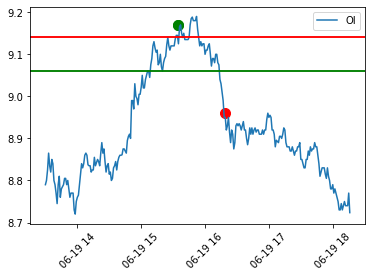

PVG analysis with profit 28.89


,profit,trade,operation,at,price,support,resistance,qty,daily change,vwap,indicators,target price,stop price
0,-8137.35,-8137.35,buy,2020-06-19 16:46:28.562909,8.45,[8.36],[8.43],963,7.37%,4.04%,"{'avg': 8.188, 'rsi': 68.76089307009825, 'macd': [0.009251496038437779, 0.010663803367295444, 0.012039670324465845, 0.012581564147611246, 0.013660465984575154], 'vwap': 8.45, 'supports': [8.271, 8.35, 8.355, 8.36, 8.365, 8.4], 'sell_macd': [0.005783943439839234, 0.006667801170406662, 0.0075244721140901305, 0.007834547237557388, 0.008493897369641346], 'slow macd': [0.008916238619772088, 0.009278238971178965, 0.009674820279736096, 0.009944246233303033, 0.010336158322155953], 'macd_signal': [0.008144481953403717, 0.008648346236182063, 0.009326611053838819, 0.009977601672593305, 0.010714174534989674], 'resistances': [8.54, 8.555], 'position_ratio': '1.8', 'sell_macd_signal': [0.005202897080000601, 0.0054958778980818135, 0.005901596741283477, 0.006288186840538259, 0.006729328946358876]}",8.65,8.35
1,28.89,8166.24,sell,2020-06-19 16:51:46.816721,8.48,[8.36],[8.43],963,7.75%,4.1%,"{'avg': 8.1924, 'rsi': [76.98517011020436, 79.138422813255], 'vwap': 8.4899, 'reasons': 'rsi max, cool-down for 5 minutes', 'movement': 0.004721893491124398, 'sell_macd': [0.00889736633789262, 0.00961568804902413, 0.011089501225892917, 0.01209390758156026, 0.013233783864135873], 'sell_macd_signal': [0.0071629364246656255, 0.0076534867495373264, 0.008340689644808445, 0.009091333232158808, 0.00991982335855422]}",8.65,8.35


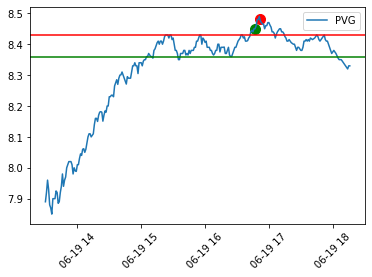

AVCT analysis with profit -96.72


,profit,trade,operation,at,price,support,resistance,qty,daily change,vwap,indicators,target price,stop price
0,-1736.93,-1736.93,buy,2020-06-19 16:00:29.757761,4.31,[4.12],[4.57],403,15.39%,14.88%,"{'avg': 4.2909, 'rsi': 68.50891327569686, 'macd': [-0.006679931937160433, -0.0007706184231111024, 0.006340902061379161, 0.013276242588414533, 0.020951780122833163], 'vwap': 4.31, 'supports': [3.75, 3.86, 4.01, 4.0218, 4.1101, 4.12], 'sell_macd': [-0.003654896317301315, 0.00021557347943268468, 0.0048391139252066395, 0.00931409201379374, 0.014238567251474876], 'slow macd': [0.016437506674625624, 0.01684731202316314, 0.017693202810405317, 0.018731036433036863, 0.020135726964801037], 'macd_signal': [-0.016013640880171737, -0.01296503638875961, -0.009103848698731857, -0.004627830441302579, 0.00048809167152456985], 'resistances': [4.57], 'position_ratio': '1.37', 'sell_macd_signal': [-0.010164240777742297, -0.008088277926307301, -0.0055027995560045125, -0.0025394212420448616, 0.0008161764566590865]}",4.79,4.07
1,-96.72,1640.21,sell,2020-06-19 16:25:12.973608,4.07,[4.12],[4.57],403,8.97%,14.76%,"{'avg': 4.2862, 'rsi': [35.365484674248236, 28.831076942457614], 'vwap': 4.0951, 'reasons': 'stopped', 'movement': -0.055684454756380355, 'sell_macd': [-0.007682651558436504, -0.008926555615649256, -0.010818863249637545, -0.01267236448067166, -0.0165494775895203], 'sell_macd_signal': [-0.00393428465084488, -0.004932738843805755, -0.006109963724972113, -0.007422443876112022, -0.009247850618793678]}",4.79,4.07


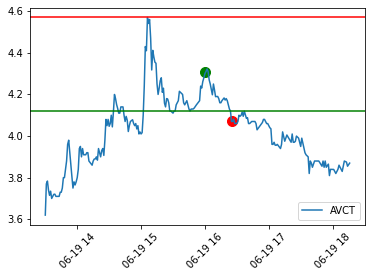

OBCI analysis with profit 105.74


,profit,trade,operation,at,price,support,resistance,qty,daily change,vwap,indicators,target price,stop price
0,-3718.40,-3718.40,buy,2020-06-19 17:14:44.433500,8.30,"[7.81, 8.1, 8.11, 8.125, 8.13, 8.1901, 8.27]",[8.49],448,14.01%,9.47%,"{'avg': 7.9697, 'rsi': 58.225334326121484, 'macd': [0.029103241428051874, 0.03291882713336847, 0.03154449881550114, 0.03409686838052828, 0.03570801982457539], 'vwap': 8.2751, 'supports': [7.28, 7.405, 7.81, 8.1, 8.11, 8.125, 8.13, 8.1901, 8.27], 'sell_macd': [0.017542966532674953, 0.019962256533313294, 0.018990764890521206, 0.02058452770275565, 0.02155908927459116], 'slow macd': [0.04285361924595321, 0.043487119952906994, 0.04320072916797635, 0.043667827083691435, 0.04402773152020778], 'macd_signal': [0.026920703436112834, 0.02812032817556396, 0.028805162303551395, 0.02986350351894677, 0.031032406780072495], 'resistances': [8.49], 'position_ratio': '6.33', 'sell_macd_signal': [0.016376629044205282, 0.017093754542026884, 0.01747315661172575, 0.01809543082993173, 0.018788162518863616]}",8.62,8.14
1,-4996.60,-1278.20,buy,2020-06-19 17:14:44.601817,8.30,"[7.81, 8.1, 8.11, 8.125, 8.13, 8.1901, 8.27]",[8.49],154,14.01%,9.47%,"{'avg': 7.9697, 'rsi': 58.225334326121484, 'macd': [0.029103241428051874, 0.03291882713336847, 0.03154449881550114, 0.03409686838052828, 0.03570801982457539], 'vwap': 8.2751, 'supports': [7.28, 7.405, 7.81, 8.1, 8.11, 8.125, 8.13, 8.1901, 8.27], 'sell_macd': [0.017542966532674953, 0.019962256533313294, 0.018990764890521206, 0.02058452770275565, 0.02155908927459116], 'slow macd': [0.04285361924595321, 0.043487119952906994, 0.04320072916797635, 0.043667827083691435, 0.04402773152020778], 'macd_signal': [0.026920703436112834, 0.02812032817556396, 0.028805162303551395, 0.02986350351894677, 0.031032406780072495], 'resistances': [8.49], 'position_ratio': '6.33', 'sell_macd_signal': [0.016376629044205282, 0.017093754542026884, 0.01747315661172575, 0.01809543082993173, 0.018788162518863616]}",8.62,8.14
2,-2465.19,2531.41,sell,2020-06-19 17:41:40.772958,8.41,"[7.81, 8.1, 8.11, 8.125, 8.13, 8.1901, 8.27]",[8.49],301,15.52%,9.96%,"{'avg': 8.005, 'rsi': [63.50357730672089, 65.67739707232639], 'vwap': 8.4011, 'reasons': 'scale-out', 'movement': 0.013253012048192701, 'sell_macd': [0.003963505115653021, 0.0025083310581752727, 0.003939256064580121, 0.010197908588212456, 0.01650078187171644], 'sell_macd_signal': [0.012469719348440681, 0.0104774416903876, 0.009169804565226104, 0.009375425369823375, 0.010800496670201987]}",8.62,8.14
3,-1185.69,1279.50,sell,2020-06-19 17:44:50.146276,8.53,"[7.81, 8.1, 8.11, 8.125, 8.13, 8.1901, 8.27]",[8.49],150,17.17%,9.97%,"{'avg': 8.0058, 'rsi': [63.50357730672089, 68.77129837004432], 'vwap': 8.4599, 'reasons': 'scale-out', 'movement': 0.005933412604042707, 'sell_macd': [0.003963505115653021, 0.0025083310581752727, 0.003939256064580121, 0.010197908588212456, 0.019092989663924698], 'sell_macd_signal': [0.012469719348440681, 0.0104774416903876, 0.009169804565226104, 0.009375425369823375, 0.01131893822864364]}",8.62,8.14
4,-544.44,641.25,sell,2020-06-19 17:44:54.872384,8.55,"[7.81, 8.1, 8.11, 8.125, 8.13, 8.1901, 8.27]",[8.49],75,17.45%,10.16%,"{'avg': 8.0199, 'rsi': [70.38176370856974, 72.5625079206175], 'vwap': 8.5122, 'reasons': 'scale-out', 'movement': 0.0, 'sell_macd': [0.003939256064580121, 0.010197908588212456, 0.020656626027559355, 0.028538008109810775, 0.03638664339325359], 'sell_macd_signal': [0.009169804565226104, 0.009375425369823375, 0.011631665501370571, 0.015012934023058613, 0.01928767589709761]}",8.62,8.14
5,-218.78,325.66,sell,2020-06-19 17:45:13.474938,8.57,"[7.81, 8.1, 8.11, 8.125, 8.13, 8.1901, 8.27]",[8.49],38,17.72%,10.17%,"{'avg': 8.0206, 'rsi': [70.38176370856974, 74.4441453535748], 'vwap': 8.5567, 'reasons': 'scale-out', 'movement': 0.0023391812865496573, 'sell_macd': [0.003939256064580121, 0.010197908588212456, 0.020656626027559355, 0.028538008109810775, 0.0384645654711786], 'sell_macd_signal': [0.009169804565226104, 0.009375425369823375, 

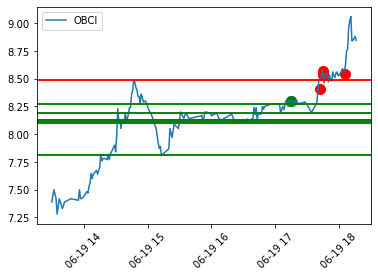

CLLS analysis with profit 37.32


,profit,trade,operation,at,price,support,resistance,qty,daily change,vwap,indicators,target price,stop price
0,-8073.50,-8073.50,buy,2020-06-19 17:09:11.315074,16.75,"[16.4, 16.49, 16.6, 16.6, 16.615, 16.65, 16.665, 16.71, 16.71, 16.75]","[16.81, 16.83, 16.86, 16.86, 16.89]",482,4.2%,2.67%,"{'avg': 16.5042, 'rsi': 58.850717415802045, 'macd': [-0.012719537182807272, -0.007986202952579902, -0.00657990174140366, 0.00018093142110231497, 0.009464422572111886], 'vwap': 16.745, 'supports': [15.96, 16.4, 16.49, 16.6, 16.6, 16.615, 16.65, 16.665, 16.71, 16.71], 'sell_macd': [-0.0063801774470029216, -0.0033114712840500715, -0.002435707114425867, 0.0019147027205370648, 0.007877168790368927], 'slow macd': [0.00394842185432509, 0.004153322210100896, 0.0038553863563635105, 0.004694661868207106, 0.0062589938575250414], 'macd_signal': [-0.028638075641497368, -0.024507701103713874, -0.020922141231251832, -0.016701526700781004, -0.011468336846202427], 'resistances': [16.81, 16.83, 16.86, 16.86, 16.89, 17.1], 'position_ratio': '1.5', 'sell_macd_signal': [-0.017174377703213364, -0.014401796419380705, -0.012008578558389738, -0.009223922302604378, -0.005803704084009717]}",17.15,16.55
1,-4019.88,4053.62,sell,2020-06-19 17:33:44.885054,16.82,"[16.4, 16.49, 16.6, 16.6, 16.615, 16.65, 16.665, 16.71, 16.71, 16.75]","[16.81, 16.83, 16.86, 16.86, 16.89]",241,4.63%,2.75%,"{'avg': 16.5168, 'rsi': [61.97389517349154, 61.973895173491556], 'vwap': 16.82, 'reasons': 'scale-out', 'movement': 0.004179104477611957, 'sell_macd': [0.02135616932379847, 0.020074294277513616, 0.02037316704304004, 0.021899909885746638, 0.02280516521921072], 'sell_macd_signal': [0.021115169456347734, 0.02090699442058091, 0.020800228945072736, 0.021020165133207515, 0.021377165150408155]}",17.15,16.55
2,-2000.28,2019.60,sell,2020-06-19 17:33:51.171917,16.83,"[16.4, 16.49, 16.6, 16.6, 16.615, 16.65, 16.665, 16.71, 16.71, 16.75]","[16.81, 16.83, 16.86, 16.86, 16.89]",120,4.7%,2.75%,"{'avg': 16.518, 'rsi': [61.97389517349154, 62.961782983804014], 'vwap': 16.8233, 'reasons': 'scale-out', 'movement': 0.000594530321046255, 'sell_macd': [0.02135616932379847, 0.020074294277513616, 0.02037316704304004, 0.021899909885746638, 0.023324645738693306], 'sell_macd_signal': [0.021115169456347734, 0.02090699442058091, 0.020800228945072736, 0.021020165133207515, 0.021481061254304674]}",17.15,16.55
3,-987.48,1012.80,sell,2020-06-19 17:52:53.958269,16.88,"[16.4, 16.49, 16.6, 16.6, 16.615, 16.65, 16.665, 16.71, 16.71, 16.75]","[16.81, 16.83, 16.86, 16.86, 16.89]",60,5.01%,2.83%,"{'avg': 16.5305, 'rsi': [59.9569727041579, 58.474077346297406], 'vwap': 16.88, 'reasons': 'scale-out', 'movement': 0.0029708853238265428, 'sell_macd': [0.026209125148476176, 0.027928281077510775, 0.028905178151074296, 0.028252043686954664, 0.026856717563138233], 'sell_macd_signal': [0.02381538602184316, 0.02463796503297668, 0.025491407656596205, 0.026043534862667896, 0.026206171402761963]}",17.15,16.55
4,37.32,1024.80,sell,2020-06-19 17:53:05.950658,16.80,"[16.4, 16.49, 16.6, 16.6, 16.615, 16.65, 16.665, 16.71, 16.71, 16.75]","[16.81, 16.83, 16.86, 16.86, 16.89]",61,4.51%,2.85%,"{'avg': 16.5328, 'rsi': [54.43510284479209, 57.589834233384686], 'vwap': 16.8868, 'reasons': 'bail', 'movement': 0.0, 'sell_macd': [0.027928281077510775, 0.028905178151074296, 0.028252043686954664, 0.02529827600469403, 0.024226531369102133], 'sell_macd_signal': [0.02463796503297668, 0.025491407656596205, 0.026043534862667896, 0.025894483091073124, 0.025560892746678925]}",17.15,16.55


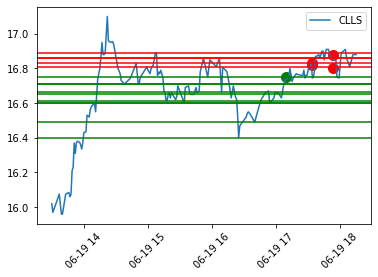

CUTR analysis with profit -132.33


,profit,trade,operation,at,price,support,resistance,qty,daily change,vwap,indicators,target price,stop price
0,-5854.60,-5854.60,buy,2020-06-19 17:14:28.414395,14.60,"[14.105, 14.19]",[14.73],401,6.65%,3.95%,"{'avg': 14.2301, 'rsi': 67.57002385678342, 'macd': [0.053236321132228426, 0.05345417927932061, 0.05193080114066895, 0.05442125073413884, 0.054954551689316844], 'vwap': 14.5921, 'supports': [14.105, 14.19, 14.42, 14.4668], 'sell_macd': [0.03154909167977138, 0.031589837762762585, 0.030504836817526026, 0.03204763040802305, 0.032314123719995536], 'slow macd': [0.029277385117849164, 0.030585860484121596, 0.031523268871108456, 0.033192554606003455, 0.03451532799967438], 'macd_signal': [0.05506056705832463, 0.054739289502523825, 0.054177591830152846, 0.05422632361095005, 0.05437196922662341], 'resistances': [14.73], 'position_ratio': '0.98', 'sell_macd_signal': [0.033371635503893875, 0.03301527595566762, 0.0325131881280393, 0.03242007658403605, 0.032398886011227944]}",15.08,14.36
1,-132.33,5722.27,sell,2020-06-19 17:48:16.845484,14.27,"[14.105, 14.19]",[14.73],401,4.24%,4.15%,"{'avg': 14.2576, 'rsi': [36.958523588094586, 27.07869366215337], 'vwap': 14.2757, 'reasons': 'stopped', 'movement': -0.0226027397260274, 'sell_macd': [-0.008505252912190286, -0.009612448581297173, -0.009311400419804272, -0.012851994054747351, -0.021677755405940857], 'sell_macd_signal': [0.002561623639111074, 0.00012680919502942433, -0.0017608327279373152, -0.003979064993299322, -0.00751880307582763]}",15.08,14.36


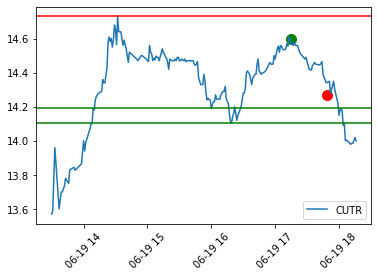

BCLI analysis with profit -120.9


,profit,trade,operation,at,price,support,resistance,qty,daily change,vwap,indicators,target price,stop price
0,-8245.38,-8245.38,buy,2020-06-19 16:04:44.595115,10.23,[10.16],"[10.3276, 10.3399]",806,4.18%,2.48%,"{'avg': 10.0634, 'rsi': 68.18095898365867, 'macd': [0.010633950772318101, 0.011004294686429716, 0.011169045107040532, 0.015159444495189689, 0.018113068579975078], 'vwap': 10.2264, 'supports': [9.79, 9.89, 9.92, 9.96, 10.025, 10.11, 10.1101, 10.12, 10.16], 'sell_macd': [0.005760557047295833, 0.0060246554953291565, 0.006152204214634693, 0.00876909666845016, 0.010694349273132175], 'slow macd': [0.0231353482418033, 0.02300951952464203, 0.02285695256890996, 0.02347970971588431, 0.024015113696822965], 'macd_signal': [0.011776241385880728, 0.011621852045990526, 0.011531290658200527, 0.012256921425598359, 0.013428150856473703], 'resistances': [10.3094, 10.3276, 10.3399, 10.3399], 'position_ratio': '1.13', 'sell_macd_signal': [0.006392241546216726, 0.0063187243360392125, 0.006285420311758308, 0.006782155583096678, 0.007564594321103778]}",10.47,10.11
1,-120.90,8124.48,sell,2020-06-19 16:21:48.579293,10.08,[10.16],"[10.3276, 10.3399]",806,2.65%,2.59%,"{'avg': 10.0745, 'rsi': [33.826480100284954, 28.943695861582064], 'vwap': 10.0805, 'reasons': 'stopped', 'movement': -0.014613880742912975, 'sell_macd': [0.010075834182073251, 0.004799704566517349, -0.0001531198685462698, -0.004010475014458947, -0.008756329998099943], 'sell_macd_signal': [0.01080634134810263, 0.009605013991785575, 0.007653387219719206, 0.005320614772883574, 0.0025052258186868707]}",10.47,10.11


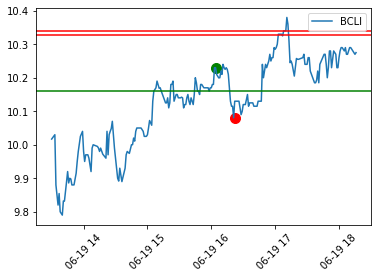

EVC analysis with profit 35.84


,profit,trade,operation,at,price,support,resistance,qty,daily change,vwap,indicators,target price,stop price
0,-1058.94,-1058.94,buy,2020-06-19 15:48:18.396728,2.22,"[2.065, 2.09]",[2.37],477,24.78%,13.69%,"{'avg': 2.0226, 'rsi': 65.36043325257998, 'macd': [0.008650384253657606, 0.008166070402849446, 0.010485584389790414, 0.01696969837511686, 0.022071842399231656], 'vwap': 2.2227, 'supports': [1.71, 1.7401, 1.76, 2.065, 2.09], 'sell_macd': [0.002930563901372807, 0.0027647151935363823, 0.004417758860240983, 0.008765354459488783, 0.012179515258129658], 'slow macd': [0.04269325493693632, 0.04188139457419604, 0.04162724972295173, 0.042286467515192605, 0.04286852040199207], 'macd_signal': [0.012415496872316948, 0.011565611578423448, 0.011349606140696841, 0.012473624587580844, 0.014393268149911006], 'resistances': [2.37], 'position_ratio': '1.11', 'sell_macd_signal': [0.004732536582477546, 0.004338972304689314, 0.004354729615799647, 0.005236854584537475, 0.006625386719255911]}",2.63,2.02
1,-521.06,537.88,sell,2020-06-19 15:52:41.000177,2.26,"[2.065, 2.09]",[2.37],238,27.03%,14.29%,"{'avg': 2.0334, 'rsi': [67.21485888843763, 69.38983812730292], 'vwap': 2.2522, 'reasons': 'scale-out', 'movement': 0.0224774774774773, 'sell_macd': [0.01300548928410361, 0.015527600974919231, 0.017717199682373952, 0.019972507770229964, 0.02250427371180308], 'sell_macd_signal': [0.006790581524450702, 0.008537985414544407, 0.010373828268110317, 0.012293564168534245, 0.014335706077188013]}",2.63,2.02
2,-247.36,273.70,sell,2020-06-19 15:53:10.949490,2.30,"[2.065, 2.09]",[2.37],119,29.28%,14.47%,"{'avg': 2.0366, 'rsi': [70.97661857172413, 72.97302612505047], 'vwap': 2.3031, 'reasons': 'scale-out', 'movement': 0.021238938053097366, 'sell_macd': [0.015527600974919231, 0.017717199682373952, 0.019972507770229964, 0.023356221763751073, 0.026816827190342174], 'sell_macd_signal': [0.008537985414544407, 0.010373828268110317, 0.012293564168534245, 0.014506095687577611, 0.016968241988130524]}",2.63,2.02
3,-107.56,139.80,sell,2020-06-19 15:53:23.937410,2.33,"[2.065, 2.09]",[2.37],60,30.97%,14.52%,"{'avg': 2.0375, 'rsi': [70.97661857172413, 75.44792150508933], 'vwap': 2.3399, 'reasons': 'scale-out', 'movement': 0.01730434782608698, 'sell_macd': [0.015527600974919231, 0.017717199682373952, 0.019972507770229964, 0.023356221763751073, 0.02846877524229008], 'sell_macd_signal': [0.008537985414544407, 0.010373828268110317, 0.012293564168534245, 0.014506095687577611, 0.017298631598520103]}",2.63,2.02
4,-35.86,71.70,sell,2020-06-19 15:54:19.956026,2.39,"[2.065, 2.09]",[2.37],30,34.34%,14.82%,"{'avg': 2.0427, 'rsi': [74.74242362634442, 76.93516316742014], 'vwap': 2.36, 'reasons': 'scale-out', 'movement': 0.01283261802575109, 'sell_macd': [0.017717199682373952, 0.019972507770229964, 0.023356221763751073, 0.027964879138394405, 0.03274091242852695], 'sell_macd_signal': [0.010373828268110317, 0.012293564168534245, 0.014506095687577611, 0.01719785237774097, 0.020306464387898165]}",2.63,2.02
5,35.84,71.70,sell,2020-06-19 15:54:23.846565,2.39,"[2.065, 2.09]",[2.37],30,34.34%,15.0%,"{'avg': 2.0459, 'rsi': [74.74242362634442, 79.34778930716325], 'vwap': 2.3898, 'reasons': 'rsi max, cool-down for 5 minutes', 'movement': 0.004184100418409952, 'sell_macd': [0.017717199682373952, 0.019972507770229964, 0.023356221763751073, 0.027964879138394405, 0.0348240293116433], 'sell_macd_signal': [0.010373828268110317, 0.012293564168534245, 0.014506095687577611, 0.01719785237774097, 0.020723087764521437]}",2.63,2.02


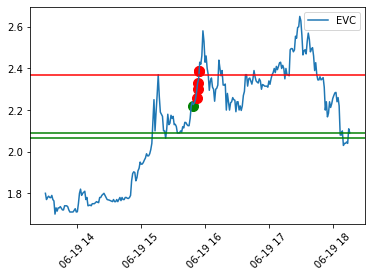

LMFA analysis with profit -17.94


,profit,trade,operation,at,price,support,resistance,qty,daily change,vwap,indicators,target price,stop price
0,-687.24,-687.24,buy,2020-06-19 16:14:11.344094,2.49,[2.22],"[2.85, 2.88]",276,10.17%,6.64%,"{'avg': 2.4102, 'rsi': 61.810955629392836, 'macd': [-0.04112589832663893, -0.026446559545210135, -0.014636290590583911, -0.004418714736212248, 0.0052323058304462045], 'vwap': 2.4963, 'supports': [1.87, 1.8761, 1.9003, 2.05, 2.22], 'sell_macd': [-0.02428982656505685, -0.014601234381126371, -0.006856860804282938, -0.00021375333136175456, 0.0060044311063864875], 'slow macd': [0.01184687080190061, 0.012797037569602931, 0.013652353676042228, 0.014577372846859227, 0.015724977653201577], 'macd_signal': [-0.05784789927301991, -0.05156763132745796, -0.04418136318008315, -0.03622883349130897, -0.027936605626957933], 'resistances': [2.85, 2.88], 'position_ratio': '1.25', 'sell_macd_signal': [-0.036446151502162606, -0.03207716807795536, -0.027033106623220875, -0.02166923596484905, -0.01613450255060194]}",3.2,2.15
1,-338.10,349.14,sell,2020-06-19 16:15:35.387791,2.53,[2.22],"[2.85, 2.88]",138,11.94%,6.65%,"{'avg': 2.4105, 'rsi': [60.55332333048028, 65.08531209716998], 'vwap': 2.5384, 'reasons': 'scale-out', 'movement': 0.020040160642570123, 'sell_macd': [-0.014601234381126371, -0.006856860804282938, -0.00021375333136175456, 0.005225210327165275, 0.012247452004885861], 'sell_macd_signal': [-0.03207716807795536, -0.027033106623220875, -0.02166923596484905, -0.016290346706446183, -0.010582786964179774]}",3.2,2.15
2,-158.70,179.40,sell,2020-06-19 16:15:39.560719,2.60,[2.22],"[2.85, 2.88]",69,15.04%,6.68%,"{'avg': 2.411, 'rsi': [60.55332333048028, 68.98597695113338], 'vwap': 2.597, 'reasons': 'scale-out', 'movement': 0.027667984189723435, 'sell_macd': [-0.014601234381126371, -0.006856860804282938, -0.00021375333136175456, 0.005225210327165275, 0.015369529926963832], 'sell_macd_signal': [-0.03207716807795536, -0.027033106623220875, -0.02166923596484905, -0.016290346706446183, -0.009958371379764179]}",3.2,2.15
3,-17.94,140.76,sell,2020-06-19 17:18:16.888924,2.04,[2.22],"[2.85, 2.88]",69,-9.74%,6.71%,"{'avg': 2.4118, 'rsi': [32.69785070712533, 31.840777175858175], 'vwap': 2.1502, 'reasons': 'stopped', 'movement': -0.17307692307692313, 'sell_macd': [-0.02205070170282486, -0.023615329315521905, -0.025047307594045165, -0.027915767192971508, -0.030307868605213617], 'sell_macd_signal': [-0.013553835433832259, -0.015566134210170187, -0.017462368886945183, -0.01955304854815045, -0.02170401255956308]}",3.2,2.15


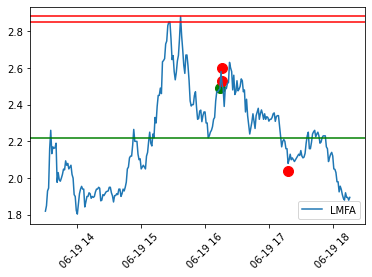

UGAZ analysis with profit -121.72


,profit,trade,operation,at,price,support,resistance,qty,daily change,vwap,indicators,target price,stop price
0,-3625.44,-3625.44,buy,2020-06-19 15:34:06.805480,10.92,[10.71],[10.905],332,4.6%,2.39%,"{'avg': 10.689, 'rsi': 67.74864958518287, 'macd': [0.021810480186859493, 0.02450401915575995, 0.028640506733607296, 0.03283928752270526, 0.03615355409510279], 'vwap': 10.9191, 'supports': [10.435, 10.6207, 10.7018, 10.71, 10.7118, 10.76, 10.81], 'sell_macd': [0.014626410296511239, 0.016258005433341438, 0.018819534040828145, 0.021407484461715143, 0.023405790186281195], 'slow macd': [0.01573799156550848, 0.01654905392818229, 0.017731004460289412, 0.019047575494489877, 0.020308367036960817], 'macd_signal': [0.007651186538611885, 0.011021753062041497, 0.014545503796354657, 0.01820426054162478, 0.02179411925232038], 'resistances': [11.02, 11.03], 'position_ratio': '0.91', 'sell_macd_signal': [0.005567203090633485, 0.007705363559175076, 0.00992819765550569, 0.01222405501674758, 0.014460402050654303]}",11.46,10.65
1,-3909.36,-283.92,buy,2020-06-19 15:34:07.080962,10.92,[10.71],[10.905],26,4.6%,2.39%,"{'avg': 10.689, 'rsi': 67.74864958518287, 'macd': [0.021810480186859493, 0.02450401915575995, 0.028640506733607296, 0.03283928752270526, 0.03615355409510279], 'vwap': 10.9191, 'supports': [10.435, 10.6207, 10.7018, 10.71, 10.7118, 10.76, 10.81], 'sell_macd': [0.014626410296511239, 0.016258005433341438, 0.018819534040828145, 0.021407484461715143, 0.023405790186281195], 'slow macd': [0.01573799156550848, 0.01654905392818229, 0.017731004460289412, 0.019047575494489877, 0.020308367036960817], 'macd_signal': [0.007651186538611885, 0.011021753062041497, 0.014545503796354657, 0.01820426054162478, 0.02179411925232038], 'resistances': [11.02, 11.03], 'position_ratio': '0.91', 'sell_macd_signal': [0.005567203090633485, 0.007705363559175076, 0.00992819765550569, 0.01222405501674758, 0.014460402050654303]}",11.46,10.65
2,-121.72,3787.64,sell,2020-06-19 16:44:41.921263,10.58,[10.71],[10.905],358,1.34%,2.57%,"{'avg': 10.7081, 'rsi': [39.47863109909263, 31.069335416261097], 'vwap': 10.6454, 'reasons': 'stopped', 'movement': -0.02564102564102558, 'sell_macd': [-0.006715873378656312, -0.008026476166728358, -0.009457770856567294, -0.009935951512849428, -0.012776924082512409], 'sell_macd_signal': [-0.007668180501651518, -0.007739839634666886, -0.008083425879046967, -0.00845393100580746, -0.00931852962114845]}",11.46,10.65


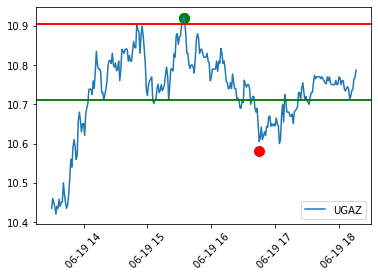

DGLY analysis with profit 43.47


,profit,trade,operation,at,price,support,resistance,qty,daily change,vwap,indicators,target price,stop price
0,-2057.58,-2057.58,buy,2020-06-19 15:37:07.840459,4.26,"[4.06, 4.11, 4.12]",[4.25],483,5.71%,1.73%,"{'avg': 4.0999, 'rsi': 67.31100276249062, 'macd': [0.024211578518169574, 0.024072700000018266, 0.024495257286366368, 0.024946032855027944, 0.02700922131645811], 'vwap': 4.2474, 'supports': [3.9363, 3.98, 4.06, 4.11, 4.12], 'sell_macd': [0.014816372504570907, 0.014671829668224667, 0.014893330968886787, 0.015132249762014993, 0.01642059882468594], 'slow macd': [0.01960994931690241, 0.019946170631649274, 0.020385139269277097, 0.02083636928851096, 0.021618030542850164], 'macd_signal': [0.017369716838809522, 0.01871031347105127, 0.01986730223411429, 0.020883048358297022, 0.02210828294992924], 'resistances': [4.42], 'position_ratio': '1.14', 'sell_macd_signal': [0.010415754657465895, 0.01126696965961765, 0.011992241921471478, 0.012620243489580182, 0.013380314556601334]}",4.66,4.06
1,43.47,2101.05,sell,2020-06-19 15:43:17.201710,4.35,"[4.06, 4.11, 4.12]",[4.25],483,7.94%,2.23%,"{'avg': 4.1199, 'rsi': [75.73123128694328, 80.83008590988082], 'vwap': 4.3701, 'reasons': 'rsi max, cool-down for 5 minutes', 'movement': 0.025821596244131533, 'sell_macd': [0.019132378349350887, 0.020402475764583983, 0.02242589614314827, 0.023971082202507432, 0.027461213129248208], 'sell_macd_signal': [0.015245911177131687, 0.016277224094622147, 0.01750695850432737, 0.018799783243963385, 0.020532069221020348]}",4.66,4.06


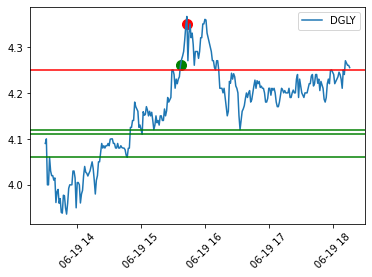

CBAY analysis with profit -96.85


,profit,trade,operation,at,price,support,resistance,qty,daily change,vwap,indicators,target price,stop price
0,-2980.00,-2980.00,buy,2020-06-19 15:49:27.910977,4.00,[3.93],"[3.97, 4.0082]",745,8.08%,5.47%,"{'avg': 3.9034, 'rsi': 66.04583763530407, 'macd': [0.001402511433342024, 0.003246547200221883, 0.005356301180537759, 0.007586378502089985, 0.009239158414962922], 'vwap': 4.0099, 'supports': [3.7, 3.8101, 3.84, 3.93], 'sell_macd': [0.0008167801974678923, 0.002029305682217153, 0.0034049189731617524, 0.004848190122298313, 0.005904658678479002], 'slow macd': [0.014816457381809034, 0.014812576058128357, 0.014926058173273304, 0.015134542025434516, 0.015300548892976273], 'macd_signal': [-0.0016647862997475518, -0.0006825195997536646, 0.0005252445563046202, 0.0019374713454616934, 0.003397808759361939], 'resistances': [4.11], 'position_ratio': '1.25', 'sell_macd_signal': [-0.0013708296333210124, -0.0006908025702133794, 0.000128341738461647, 0.0010723114152289804, 0.002038780867878985]}",4.27,3.88
1,-96.85,2883.15,sell,2020-06-19 16:14:58.153465,3.87,[3.93],"[3.97, 4.0082]",745,4.57%,5.52%,"{'avg': 3.9054, 'rsi': [32.397655545249094, 23.979534024355505], 'vwap': 3.8962, 'reasons': 'stopped', 'movement': -0.030000000000000027, 'sell_macd': [-0.0023922094159556373, -0.002094450733936881, -0.0027806848682869756, -0.0047078714032573465, -0.00835622621747767], 'sell_macd_signal': [-0.002155202604580575, -0.0021430522304518363, -0.0022705787580188644, -0.0027580372870665607, -0.0038776750731487823]}",4.27,3.88


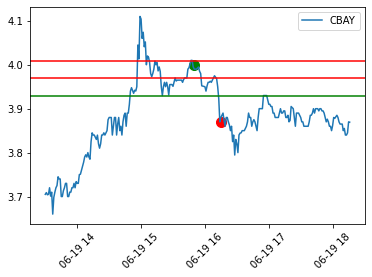

GNUS analysis with profit -95.76


,profit,trade,operation,at,price,support,resistance,qty,daily change,vwap,indicators,target price,stop price
0,-1193.01,-1193.01,buy,2020-06-19 13:52:09.377031,2.99,"[2.815, 2.95]","[3.8701, 3.89, 3.94]",399,3.46%,2.53%,"{'avg': 2.9632, 'rsi': 69.53107311254503, 'macd': [0.02741183841312589, 0.03011725693146783, 0.035084553412430886, 0.03777078793839994, 0.039636404299904004], 'vwap': 2.9978, 'supports': [2.815], 'sell_macd': [0.016588212744451436, 0.018290376403368835, 0.021457122418066188, 0.02312137746305032, 0.024242597271309396], 'slow macd': [0.014948348234485653, 0.0161247677415699, 0.017821066108156813, 0.019191677174563715, 0.020460373438100365], 'macd_signal': [0.02247676412108924, 0.024004862683164957, 0.02622080082901814, 0.028530798250894503, 0.030751919460696404], 'resistances': [3.94], 'position_ratio': '5.35', 'sell_macd_signal': [0.013581680018967252, 0.014523419295847568, 0.01591015992029129, 0.017352403428843095, 0.018730442197336356]}",3.48,2.75
1,-95.76,1097.25,sell,2020-06-19 15:49:15.023667,2.75,"[2.815, 2.95]","[3.8701, 3.89, 3.94]",399,-4.84%,1.03%,"{'avg': 2.9198, 'rsi': [25.870658767465887, 22.654772160995993], 'vwap': 2.755, 'reasons': 'stopped', 'movement': -0.08026755852842817, 'sell_macd': [-0.004488031672928994, -0.005262628091756927, -0.006057604157184482, -0.006858136102229739, -0.007912341045093196], 'sell_macd_signal': [-0.004864799200077664, -0.004944364978413517, -0.005167012814167709, -0.0055052374717801155, -0.005986658186442732]}",3.48,2.75


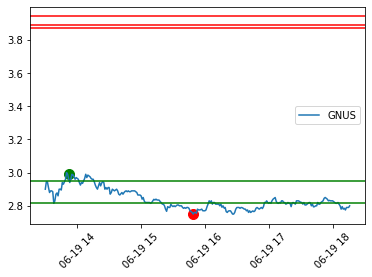

ELMD analysis with profit -3193.52


,profit,trade,operation,at,price,support,resistance,qty,daily change,vwap,indicators,target price,stop price
0,-3193.52,-3193.52,buy,2020-06-19 17:01:52.501853,15.28,"[14.41, 14.555, 14.81, 14.8205, 14.87, 14.87, 14.885, 14.9, 14.9001, 14.98, 14.985, 15.0, 15.0601, 15.1572, 15.22]",[15.33],209,3.38%,1.32%,"{'avg': 14.9744, 'rsi': 62.80042161421906, 'macd': [-0.01090923986142478, 0.0027710066807724587, 0.003095176972456315, 0.019260322620100467, 0.033301273510762286], 'vwap': 15.275, 'supports': [14.41, 14.555, 14.81, 14.8205, 14.87, 14.87, 14.885, 14.9, 14.9001, 14.98, 14.985, 15.0, 15.03, 15.03, 15.0601, 15.1572, 15.22], 'sell_macd': [-0.008676372460435289, 0.00044416040268480117, 0.0007972488622254303, 0.011446444429887848, 0.020634824814692365], 'slow macd': [0.018865108517889695, 0.020815597171196742, 0.020499248511690382, 0.023372533094029535, 0.02629853776879365], 'macd_signal': [-0.015310642788751045, -0.011694312894846345, -0.008736414921385813, -0.0031370674130885567, 0.004150600771681612], 'resistances': [15.33], 'position_ratio': '0.83', 'sell_macd_signal': [-0.012715911762684847, -0.010083897329610918, -0.007907668091243648, -0.004036845587017349, 0.0008974884933245948]}",16.2,14.82


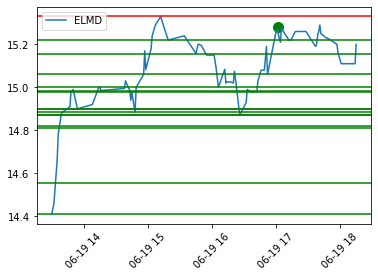

In [119]:
for symbol in minute_history:   
    symbol_df = trades.loc[trades['symbol']==symbol]
    start_date = symbol_df["tstamp"].min().to_pydatetime()
    start_date = start_date.replace(hour=9, minute=30)
    cool_down_date = start_date + timedelta(minutes=5)
    minute_history_index = minute_history[symbol]["close"].index.get_loc(start_date, method='nearest')
    cool_minute_history_index = minute_history[symbol]["close"].index.get_loc(cool_down_date, method='nearest')
    open_price = minute_history[symbol]["close"][cool_minute_history_index]
    plt.plot(minute_history[symbol]["close"][minute_history_index:].between_time("9:30", "16:00"), label=symbol)
    plt.xticks(rotation=45)
 
    delta = 0
    profit = 0

    operations = []
    deltas = []
    profits = []
    times = []
    prices = []
    qtys = []
    indicators = []
    target_price = []
    stop_price = []
    resistances = []
    supports = []
    daily_change = []
    precent_vwap = []
    for index, row in symbol_df.iterrows(): 
        if row['operation'] == 'buy':
            try:
                now = int(row['client_time'])
                continue
            except Exception:
                pass 
            
            resistance = find_resistance(row['price'], minute_history[symbol], row['tstamp'])
            if resistance:
                for r in resistance:
                    plt.axhline(y=r, color="r")
            support = find_support(row['price'], minute_history[symbol], row['tstamp'])
            if support:
                for s in support:
                    plt.axhline(y=s, color="g")  

        delta = row['price'] * row['qty'] * (1 if row['operation'] == 'sell' or row['operation'] == 'buy_short' else -1)
        profit += delta
        plt.scatter(row['tstamp'].to_pydatetime(), row['price'], c='g' if row['operation'] == 'buy' or row['operation'] == 'sell_short' else 'r', s=100)
        deltas.append(round(delta, 2))
        profits.append(round(profit, 2))
        operations.append(row['operation'])
        times.append(pd.to_datetime(row['tstamp']))
        prices.append(row['price'])
        qtys.append(row['qty'])
        indicators.append(row['indicators'])
        target_price.append(row['target_price'])
        stop_price.append(row['stop_price'])    
        resistances.append(resistance)
        supports.append(support)
        daily_change.append(f"{round(100.0 * (row['price'] - open_price) / open_price, 2)}%")
        precent_vwap.append(f"{round(100.0 * (row['indicators']['avg'] - open_price) / open_price, 2)}%" if 'avg' in row['indicators'] else "")

    d = {
        'profit': profits,
        'trade': deltas,
        'operation': operations,
        'at': times,
        'price': prices,
        'support': supports,
        'resistance': resistances,
        'qty': qtys,
        'daily change': daily_change,
        'vwap': precent_vwap,
        'indicators': indicators,
        'target price': target_price,
        'stop price': stop_price
        
    }   
    print (f'{symbol} analysis with profit {round(profit, 2)}')
    display(HTML(pd.DataFrame(data=d).to_html()))
    plt.legend()
    plt.show()